# MFI Assignment 7
### Raghav Srivastava
### GTID: 903851312

In [181]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import zipfile
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display
os.chdir("/Users/raghav/Documents/Assignment 7")

### Auxiliary Functions

In [182]:
def plotSeriesFromDataFrame(dataFrame, title=None, xLabel='Date', yLabel='Level', 
                            legendLoc='best', fileName=None, rotateXTicks = True,
                           legendOutside = False):

    plt.figure(figsize=(10, 6), dpi = 400)
    for column in dataFrame.columns:
        plt.plot(dataFrame.index, dataFrame[column], label=column, linestyle='-')

    plt.xlabel(xLabel, fontsize=12)
    plt.ylabel(yLabel, fontsize=12)
    plt.title(title, fontsize=14)
    
    years_to_keep = range(dataFrame.index.year.min(), dataFrame.index.year.max() + 1)
    plt.xticks([pd.Timestamp(year, 1, 1) for year in years_to_keep], years_to_keep)

    
    if legendOutside:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, 
           bbox_transform=plt.gca().transAxes)
    else:
        plt.legend(loc=legendLoc, fontsize=10)
    plt.grid(True)
    if rotateXTicks:
        plt.xticks(rotation=45)

    plt.show()

In [183]:
def descriptiveStats(df):

    descStats = df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).rename(index={'1%': 'p1','5%': 'p5', '25%': 'p25', '50%': 'p50', '75%': 'p75', '95%': 'p95', '99%': 'p99', "count": "N"}).T.round(2)
    descStats["skew"] = df.skew()
    descStats["kurtosis"] = df.kurt()
    return descStats

### Getting Fama-French and Momentum Data

In [184]:
# Define the URLs for the Fama-French data and momentum factor
ff_data_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
momentum_data_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"

# Define the local directory where you want to save the downloaded data
download_dir = os.getcwd()

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

# Download the Fama-French data ZIP file
response_ff = requests.get(ff_data_url)
if response_ff.status_code == 200:
    with open(os.path.join(download_dir, "FamaFrenchData.zip"), "wb") as ff_file:
        ff_file.write(response_ff.content)
else:
    print("Failed to download Fama-French data.")

# Download the Momentum factor ZIP file
response_momentum = requests.get(momentum_data_url)
if response_momentum.status_code == 200:
    with open(os.path.join(download_dir, "MomentumData.zip"), "wb") as momentum_file:
        momentum_file.write(response_momentum.content)
else:
    print("Failed to download momentum factor data.")

# Unzip the downloaded files
with zipfile.ZipFile(os.path.join(download_dir, "FamaFrenchData.zip"), 'r') as ff_zip_ref:
    ff_zip_ref.extractall(download_dir)

with zipfile.ZipFile(os.path.join(download_dir, "MomentumData.zip"), 'r') as momentum_zip_ref:
    momentum_zip_ref.extractall(download_dir)

# List the files in the unzipped directory
extracted_files = os.listdir(download_dir)

print("Fama-French and Momentum data have been downloaded and extracted successfully.")
    
mom = pd.read_csv('F-F_Momentum_Factor.csv', usecols=[0, 1], skiprows=range(0, 13), nrows=1173 - 13)    
mom['Unnamed: 0'] = mom['Unnamed: 0'].astype(str)
mom['date'] = pd.to_datetime(mom['Unnamed: 0'], format='%Y%m')
mom.drop('Unnamed: 0', axis=1, inplace=True)
mom.set_index('date', inplace=True)

fama = pd.read_csv('F-F_Research_Data_Factors.csv', usecols=[0, 1, 2, 3, 4], skiprows=range(0, 3), nrows=1169 - 3)    
fama['Unnamed: 0'] = fama['Unnamed: 0'].astype(str)
fama['date'] = pd.to_datetime(fama['Unnamed: 0'], format='%Y%m')
fama.drop('Unnamed: 0', axis=1, inplace=True)
fama.set_index('date', inplace=True)
factorData = mom.merge(fama, left_index = True, right_index = True, how = "inner")
factorData = factorData/100

Fama-French and Momentum data have been downloaded and extracted successfully.


### Reading GNP Price Index Level (For Ohlson Score)

In [185]:
gnp = pd.read_csv("gnp.csv")
gnp = gnp.rename(columns = {"DATE": "date"})
gnp = gnp.set_index("date")
gnp.index = pd.to_datetime(gnp.index)
gnp.columns = ["gnp"]
gnp = gnp.resample("M").ffill()
gnp.index = pd.to_datetime(gnp.index).to_period('M').to_timestamp()

### 1. Reading CRSP Data and Lagging By One Month

In [186]:
crsp = pd.read_csv("msf_1926_2022.csv")
crsp = crsp[crsp["SHRCD"].isin([10, 11])].set_index("date")
crsp.index = pd.to_datetime(crsp.index)
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp["EXCESSRET"] = crsp["RET"] - crsp["vwretd"]
crsp["MKTCAP"] = abs(crsp["PRC"])*abs(crsp["SHROUT"])
crsp.index = pd.to_datetime(crsp.index).to_period('M').to_timestamp()
crsp = crsp[["CUSIP", "RET", "EXCESSRET", "MKTCAP", "vwretd", "PRC"]]
crsp["CUSIP"] = crsp["CUSIP"].astype(str)
crsp = crsp.rename(columns = {"CUSIP": "cusip"})

start_time = time.time()
def crspLag(group):
    df = group[1]
    df = df.shift(periods = 1)
    return df


crspGrouped = list(crsp.groupby("cusip"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(crspLag, crspGrouped))
crsp = pd.concat(results)
elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))
crsp = crsp.sort_index()
crsp['year'] = crsp.index.year

This took 0 minutes 25 seconds


### 1. Reading COMPUSTAT Data and Lagging By 3 Months

In [187]:
compustat = pd.read_csv("funda_2022.csv")
compustat = compustat.rename(columns = {"datadate": "date"})
compustat = compustat.set_index("date")
compustat.index = pd.to_datetime(compustat.index)
compustat.index = pd.to_datetime(compustat.index).to_period('M').to_timestamp()
compustat = compustat[["teq",
                       "oancf", "ivncf", "fincf",
                       "sale",
                       "dv",
                       "ni", "at",
                       "re", "ebit", "prcc_f", "csho", "lt",
                       "act", "lct", "cusip", "dlc", "dltt", "seq"]]
compustat["cusip"] = compustat["cusip"].astype(str)
compustat = compustat.merge(gnp, left_index = True, right_index = True, how = "left")


### 2. Calculating Financial Data and Ratios

In [188]:
compustat['year'] = compustat.index.year
compustat["bookValue"] = compustat["teq"]
compustat["cashFlow"] = compustat["oancf"] + compustat["ivncf"] + compustat["fincf"]
compustat["sales"] = compustat["sale"]
compustat["dividends"] = compustat["dv"]
compustat["investment"] = compustat["ivncf"]
compustat["profitability(ROA)"] = compustat["ni"]/compustat["at"]
compustat["assetTurnover"] = compustat["sale"]/compustat["at"]
compustat["bookValueOfDebt"] = compustat["dlc"] + compustat["dltt"]
compustat["bookValueOfAssets"] = compustat["at"]
compustat["netIncome"] = compustat["ni"]
compustat["bookLeverage"] = (compustat["dlc"] + compustat["dltt"])/(compustat["dlc"] + compustat["dltt"] + compustat["seq"])
compustat["marketValueOfEquity/totalLiabilities"] = (compustat["prcc_f"]*compustat["csho"])/compustat["lt"]
compustat["marketValue"] = compustat["prcc_f"]*compustat["csho"]
compustat["altmanZScore"] = 1.2*(compustat["act"] - compustat["lct"])/compustat["at"] + 1.4*compustat["re"]/compustat["at"] + 3.3*compustat["ebit"]/compustat["at"] + 0.6*compustat["marketValue"]/compustat["lt"] + 0.99*compustat["sale"]/compustat["at"]



compustat = compustat.sort_index()
compustat = compustat.loc["1970-01-01":]

### 2. Descriptive Stats of Financial Data and Ratios for Years of Interest

In [189]:
start_time = time.time()
def compustatAnnualTask(group):
    df = group[1]
    cusip = group[0]
    df = df.drop(columns = ["cusip"])
    df = df.resample("Y").mean()
    df["cusip"] = cusip
    return df


compustatGrouped = list(compustat.groupby("cusip"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(compustatAnnualTask, compustatGrouped))
compustatAnnual = pd.concat(results)
compustatAnnual["Year"] = compustatAnnual.index.year
compustatAnnual = compustatAnnual.dropna()
compustatAnnual.replace([np.inf, -np.inf], np.nan, inplace=True)
compustatAnnual.dropna(inplace=True)
elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))

yearsOfInterest = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2021]
compustatDesc = compustatAnnual[compustatAnnual["Year"].isin(yearsOfInterest)]
compustatDesc = compustatDesc[["bookValue",
                               "cashFlow",
                               "sales",
                               "dividends",
                               "investment",
                               "profitability(ROA)",
                               "assetTurnover",
                               "bookValueOfDebt",
                               "bookValueOfAssets",
                               "netIncome",
                               "bookLeverage",
                               "marketValueOfEquity/totalLiabilities",
                               "marketValue",
                               "altmanZScore",
                               "Year"]]



stats = compustatDesc.describe()
display(stats.T)

This took 2 minutes 18 seconds


count         mean           std  \
bookValue                             22288.0  2349.443767  10543.399506   
cashFlow                              22288.0    75.190945   1055.318596   
sales                                 22288.0  4204.447933  18995.407236   
dividends                             22288.0   128.693168    708.206476   
investment                            22288.0  -404.154418   2145.076687   
profitability(ROA)                    22288.0    -4.824722    243.007917   
assetTurnover                         22288.0     0.836072      1.379540   
bookValueOfDebt                       22288.0  1925.413365   8567.003964   
bookValueOfAssets                     22288.0  6256.733563  25884.789623   
netIncome                             22288.0   259.127216   1961.600329   
bookLeverage                          22288.0     0.260729     12.310839   
marketValueOfEquity/totalLiabilities  22288.0    38.851335   2000.184972   
marketValue                           22288.0  7458.478281  44627.649009   
altmanZScore                          22288.0   -95.016549   3242.891287   
Year                                  22288.0  2014.558013      6.516130   

                                                min          25%          50%  \
bookValue                             -18075.000000    19.465250   171.674500   
cashFlow                              -31470.000000    -4.795750     0.990500   
sales                                  -1181.604000    16.004000   243.601500   
dividends                                 -0.023000     0.000000     0.000000   
investment                            -67153.000000  -137.823000   -14.220500   
profitability(ROA)                    -29700.500000    -0.186968     0.009193   
assetTurnover                            -31.586933     0.257920     0.617782   
bookValueOfDebt                            0.000000     1.227750    36.654000   
bookValueOfAssets                          0.001000    53.393500   375.688000   
netIncome                             -23119.000000   -14.694500     1.034000   
bookLeverage                            -916.750000     0.013766     0.242468   
marketValueOfEquity/totalLiabilities       0.000000     1.052724     2.702729   
marketValue                                0.000000    65.826375   457.238685   
altmanZScore                         -307168.873443     0.694073     2.598990   
Year                                    1990.000000  2010.000000  2015.000000   

                                              75%           max  
bookValue                              879.753250  2.516350e+05  
cashFlow                                33.538500  7.236950e+04  
sales                                 1659.680250  5.569330e+05  
dividends                                7.032250  1.652100e+04  
investment                              -0.153000  2.130800e+04  
profitability(ROA)                       0.063885  1.992432e+03  
assetTurnover                            1.107134  8.300000e+01  
bookValueOfDebt                        632.186750  2.452442e+05  
bookValueOfAssets                     2331.700750  6.012006e+05  
netIncome                               72.070000  9.468000e+04  
bookLeverage                             0.512271  1.365312e+03  
marketValueOfEquity/totalLiabilities     7.885757  2.805348e+05  
marketValue                           2711.491865  2.324390e+06  
altmanZScore                             5.271555  1.683065e+05  
Year                                  2020.000000  2.021000e+03

### 3. Mean and Median of Fin Ratios Over Time

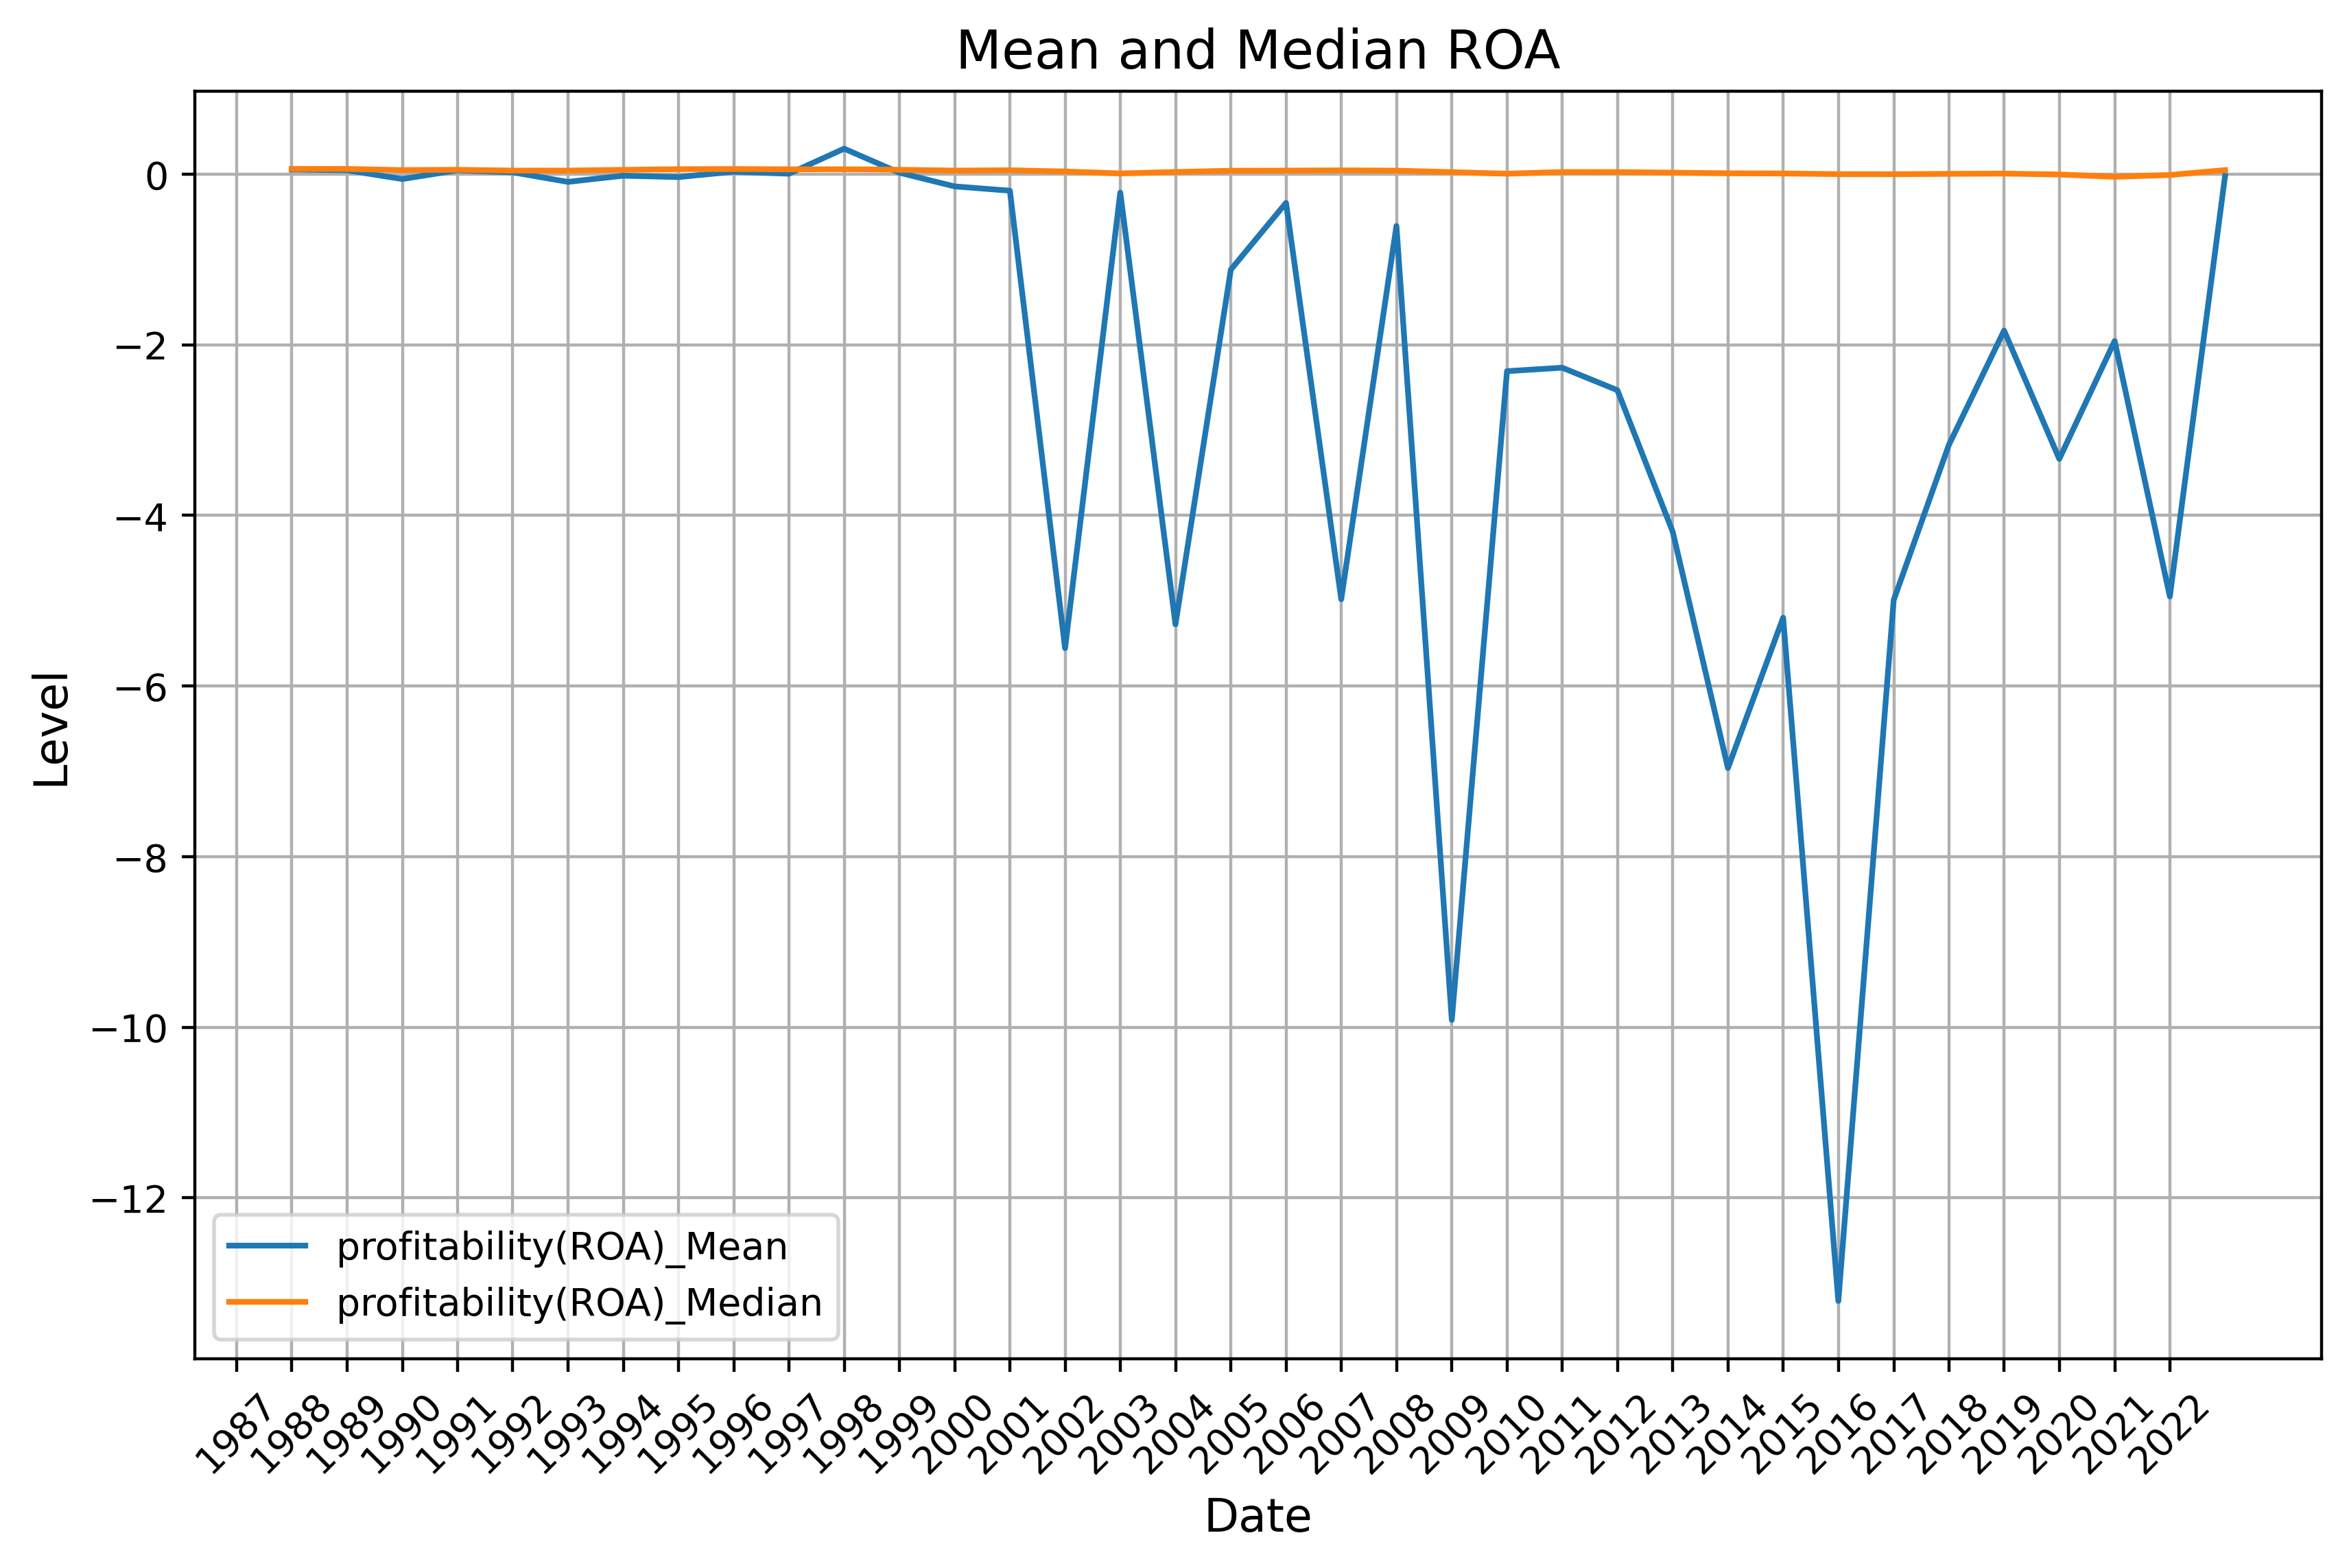

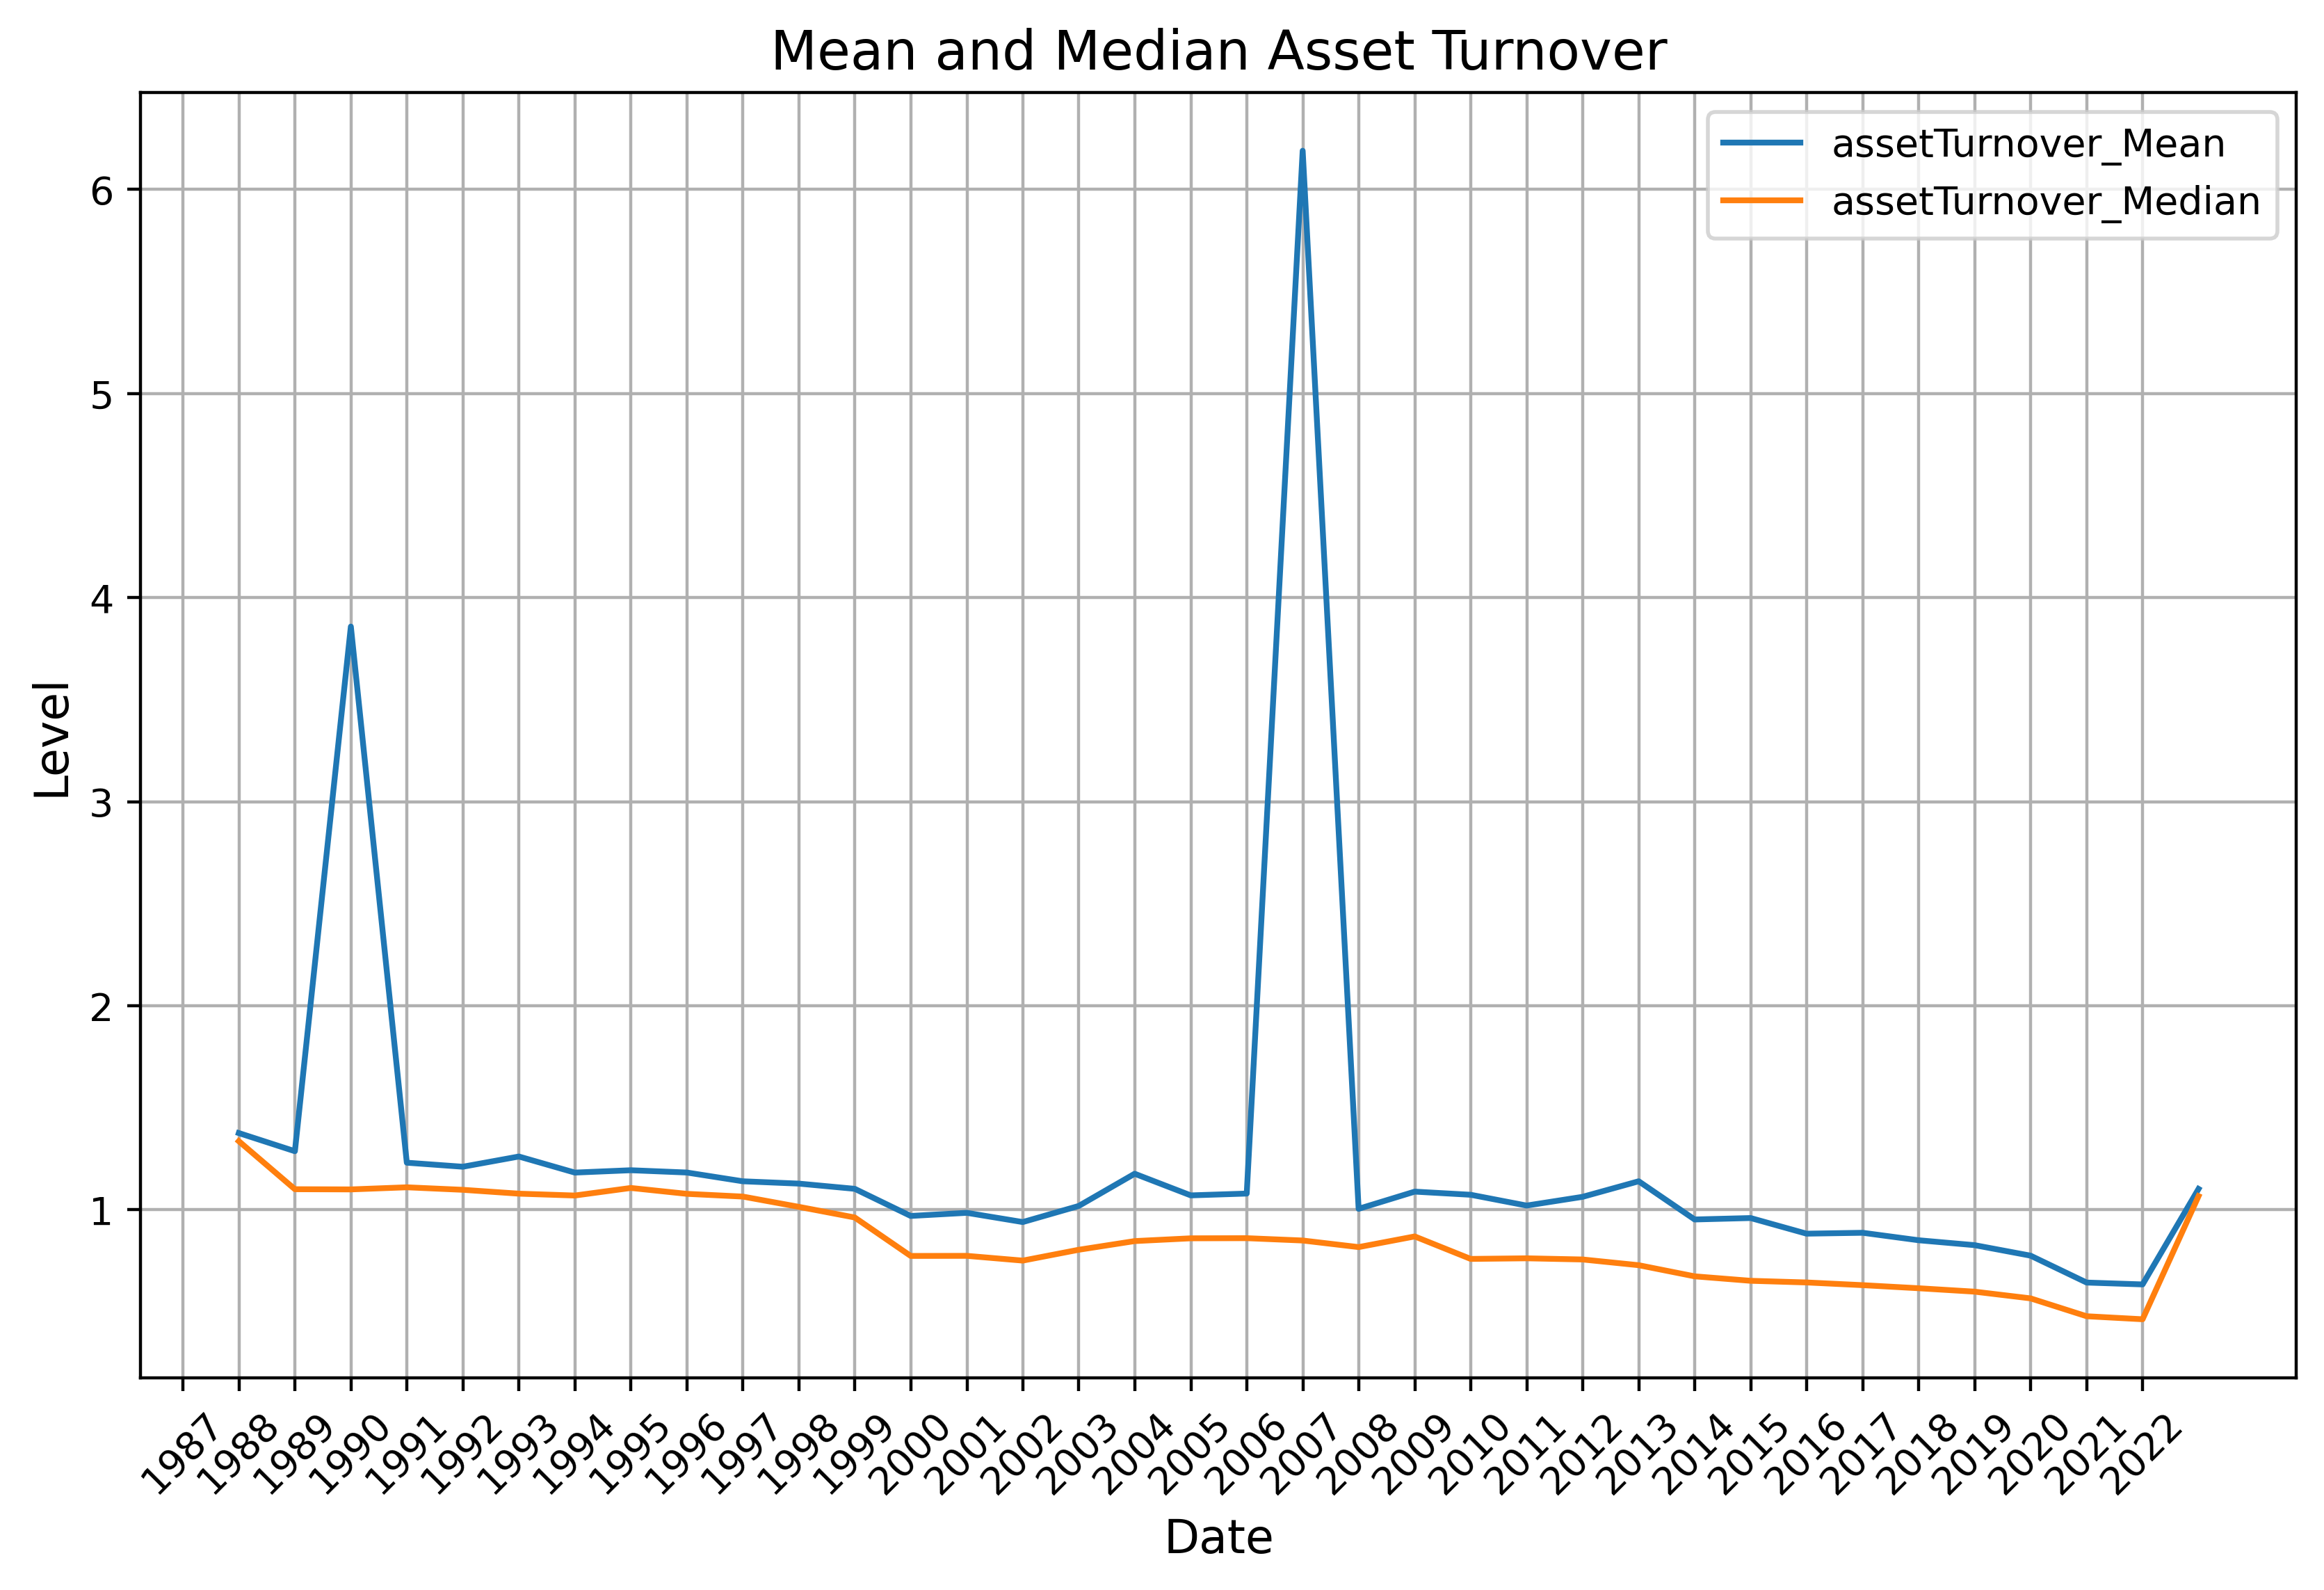

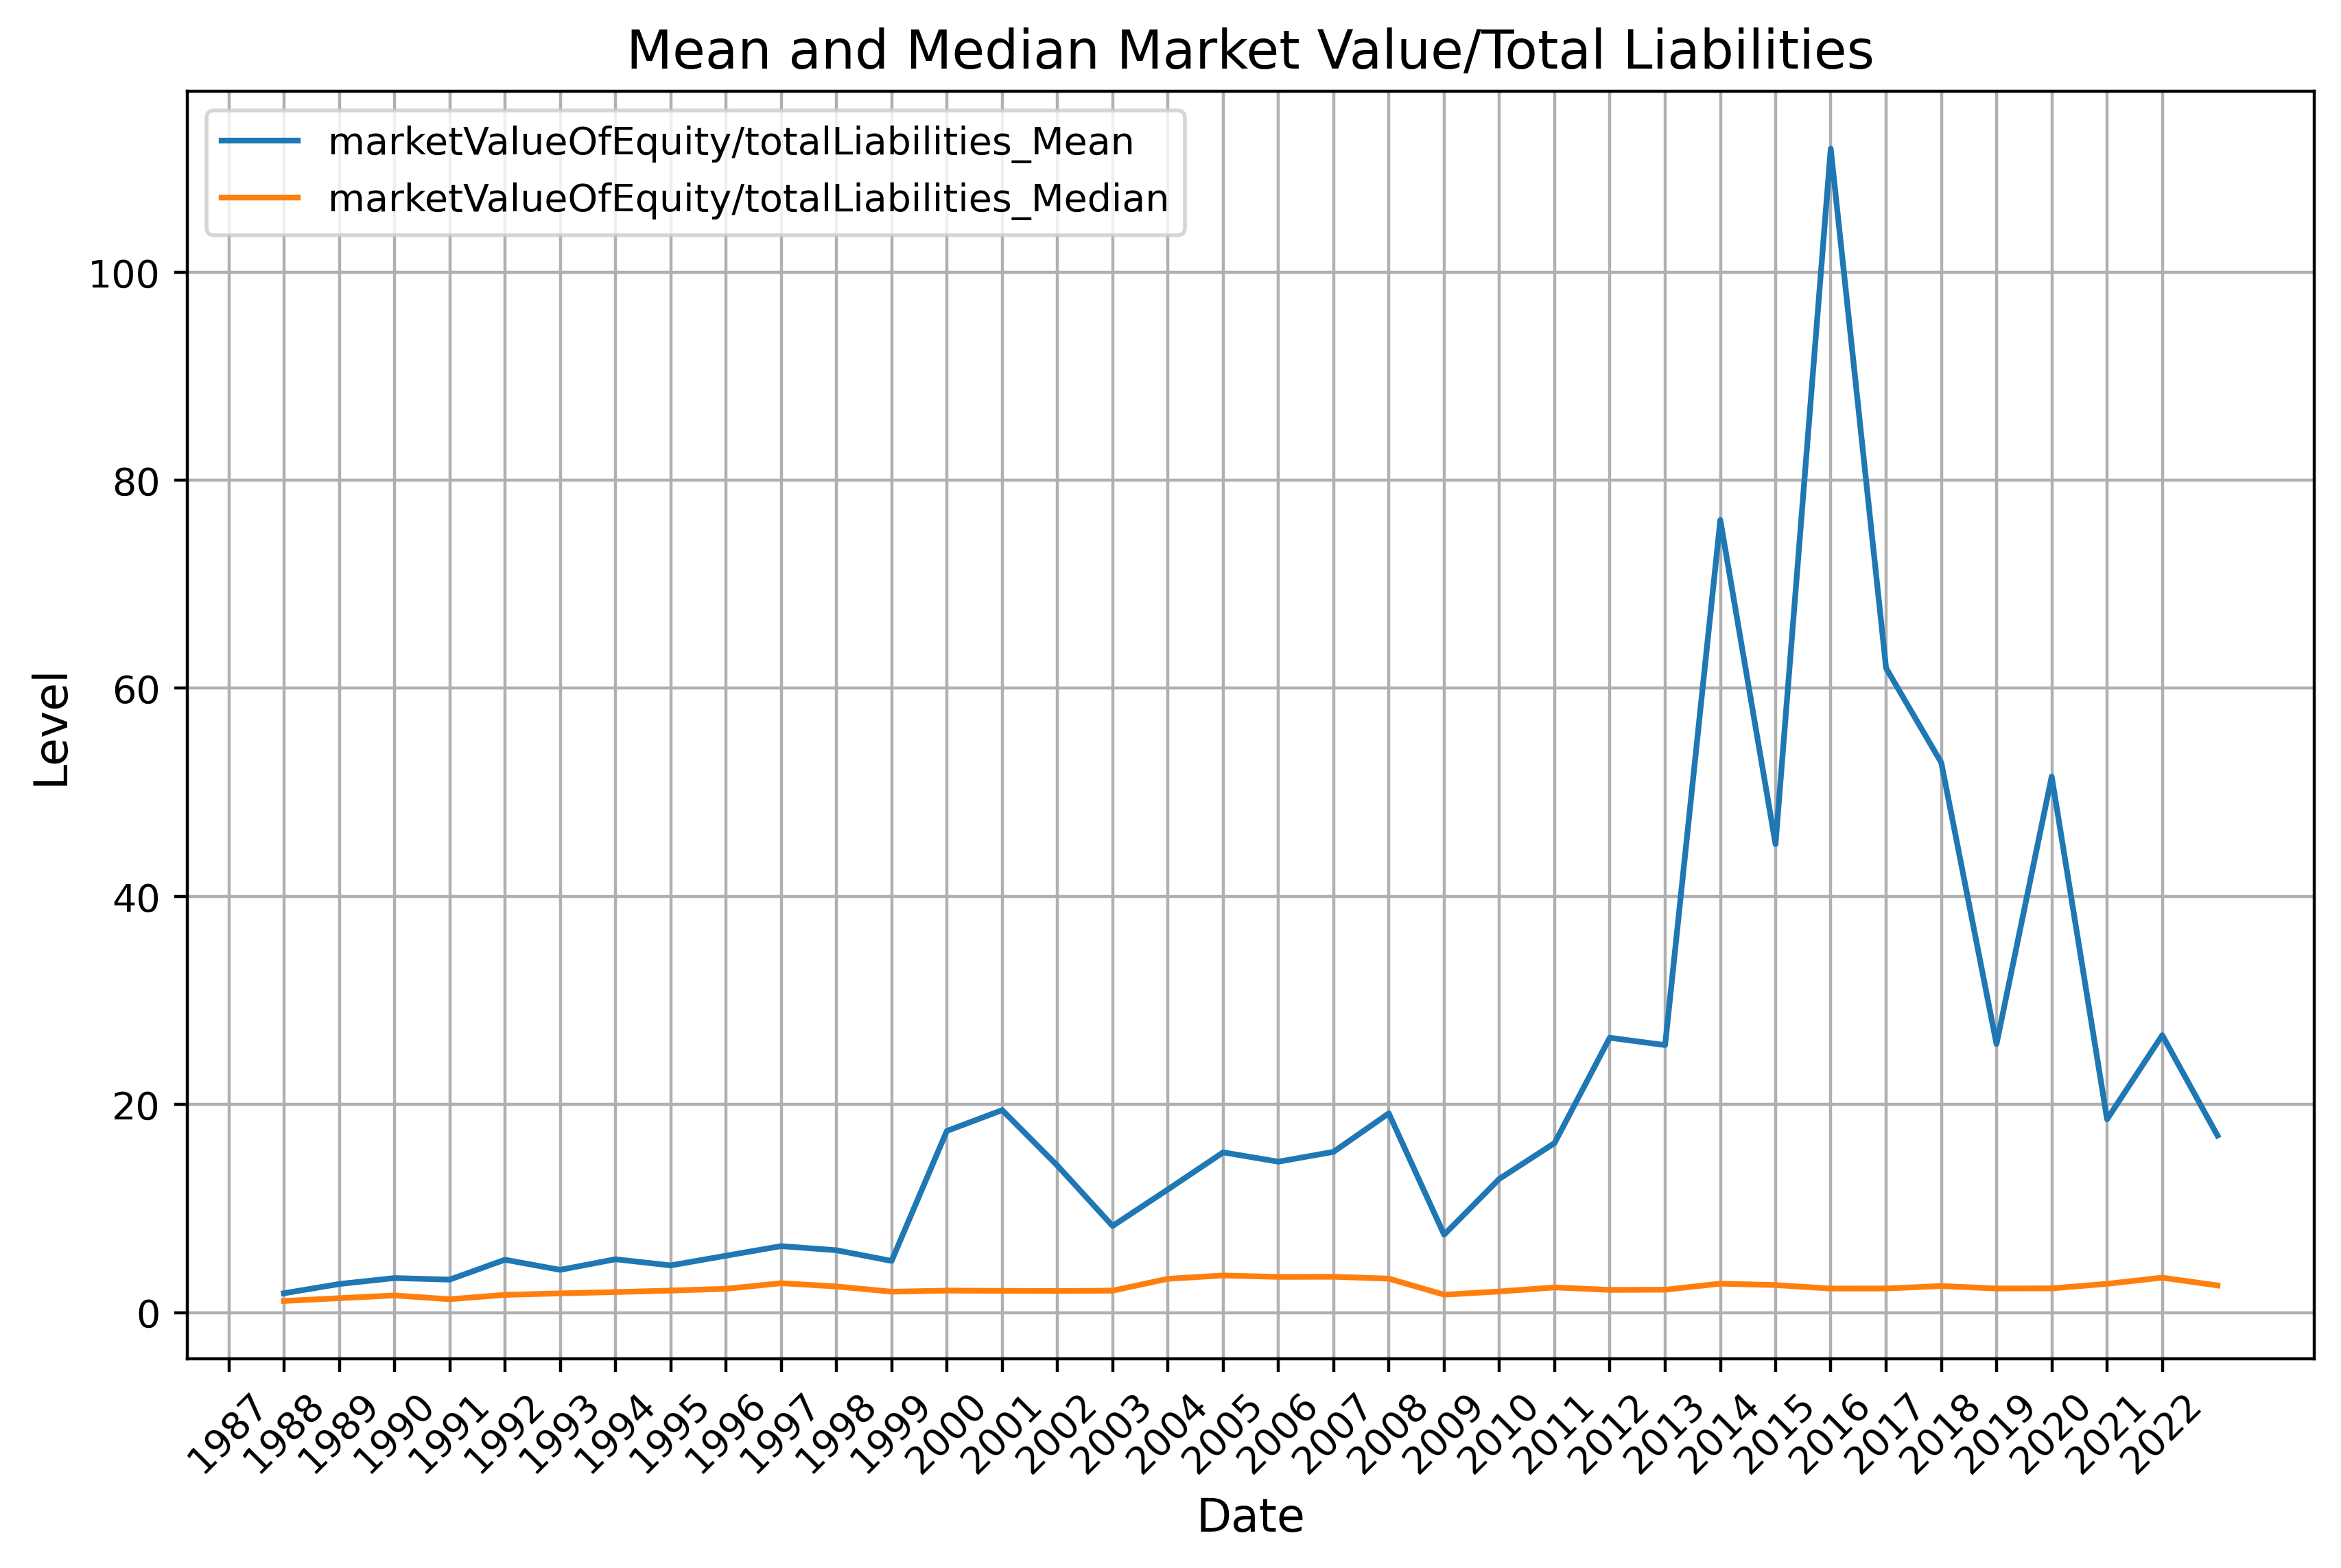

In [190]:
compustatAnnualPlot = compustatAnnual[["profitability(ROA)", "assetTurnover", "marketValueOfEquity/totalLiabilities"]]
compustatAnnualPlotMean = compustatAnnualPlot.resample("Y").mean()
compustatAnnualPlotMedian = compustatAnnualPlot.resample("Y").median()


ROA = compustatAnnualPlotMean[["profitability(ROA)"]].merge(compustatAnnualPlotMedian[["profitability(ROA)"]],
                                                          left_index = True, right_index = True,
                                                          suffixes = ("_Mean", "_Median"))

assetTurnover = compustatAnnualPlotMean[["assetTurnover"]].merge(compustatAnnualPlotMedian[["assetTurnover"]],
                                                          left_index = True, right_index = True,
                                                          suffixes = ("_Mean", "_Median"))

mktvalByLiabilities = compustatAnnualPlotMean[["marketValueOfEquity/totalLiabilities"]].merge(compustatAnnualPlotMedian[["marketValueOfEquity/totalLiabilities"]],
                                                          left_index = True, right_index = True,
                                                          suffixes = ("_Mean", "_Median"))

plotSeriesFromDataFrame(ROA, title="Mean and Median ROA", xLabel='Date', yLabel='Level', 
                            legendLoc='best', fileName=None, rotateXTicks = True,
                           legendOutside = False)

plotSeriesFromDataFrame(assetTurnover, title="Mean and Median Asset Turnover", xLabel='Date', yLabel='Level', 
                            legendLoc='best', fileName=None, rotateXTicks = True,
                           legendOutside = False)


plotSeriesFromDataFrame(mktvalByLiabilities, title="Mean and Median Market Value/Total Liabilities", xLabel='Date', yLabel='Level', 
                            legendLoc='best', fileName=None, rotateXTicks = True,
                           legendOutside = False)

### Analysis
##### 
- Mean asset turnover saw sharp rises during the 2008 financial crises, as companies disposed off their assets to stay afloat artificiually increasing the asset turnover.
- Mean market values seem to have been rising since the 2000s while a decline has been observed since 2016. Since 2016 as companies pick up more debt the market value to liabilities ratio has gone down.
- The mean ROA has generally been negative while the median value has been a little more than zero. 
- The mean Altman Z-Score has been in decline signifying that larger number of companie shave been at risk of bankrupcy. 
- The mean Ohlson score ben on the steady rise signifying that larger number of companies are at risk of default within two years. 


### 4. Fin Data 5 Year Trailing Averages, Ratios Time Series and Altman Z-Score, Ohlsen Score

This took 5 minutes 35 seconds


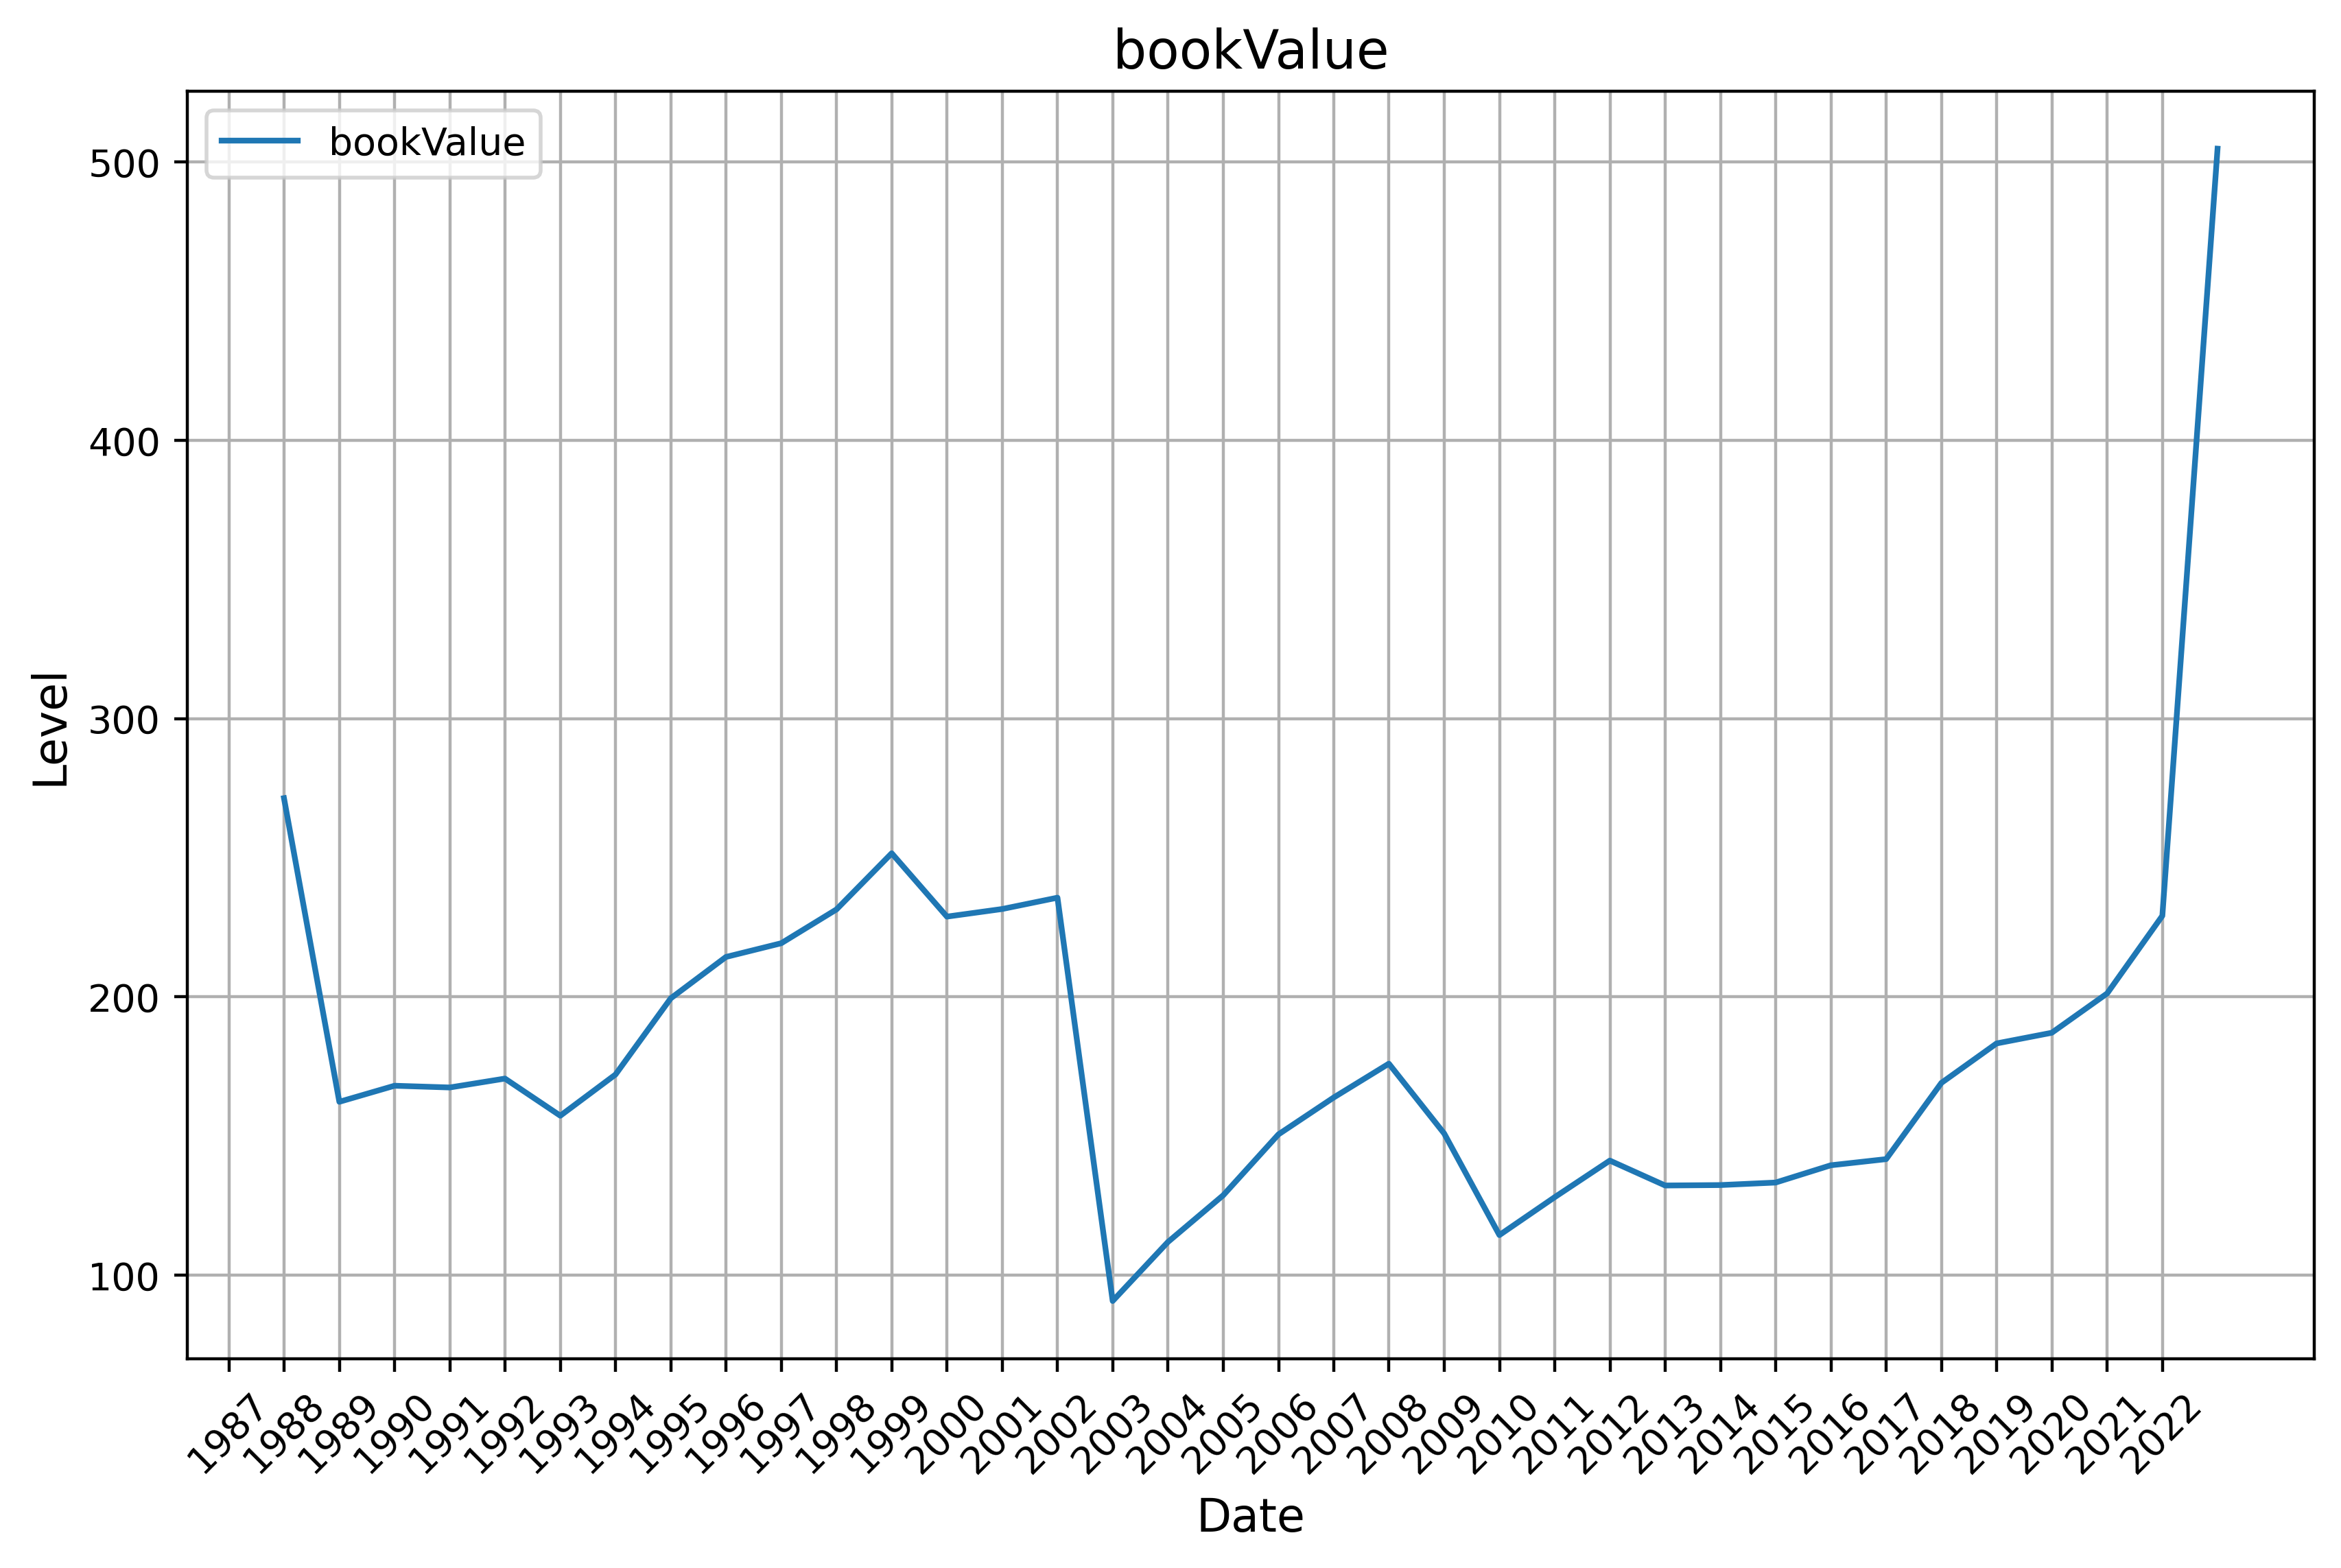

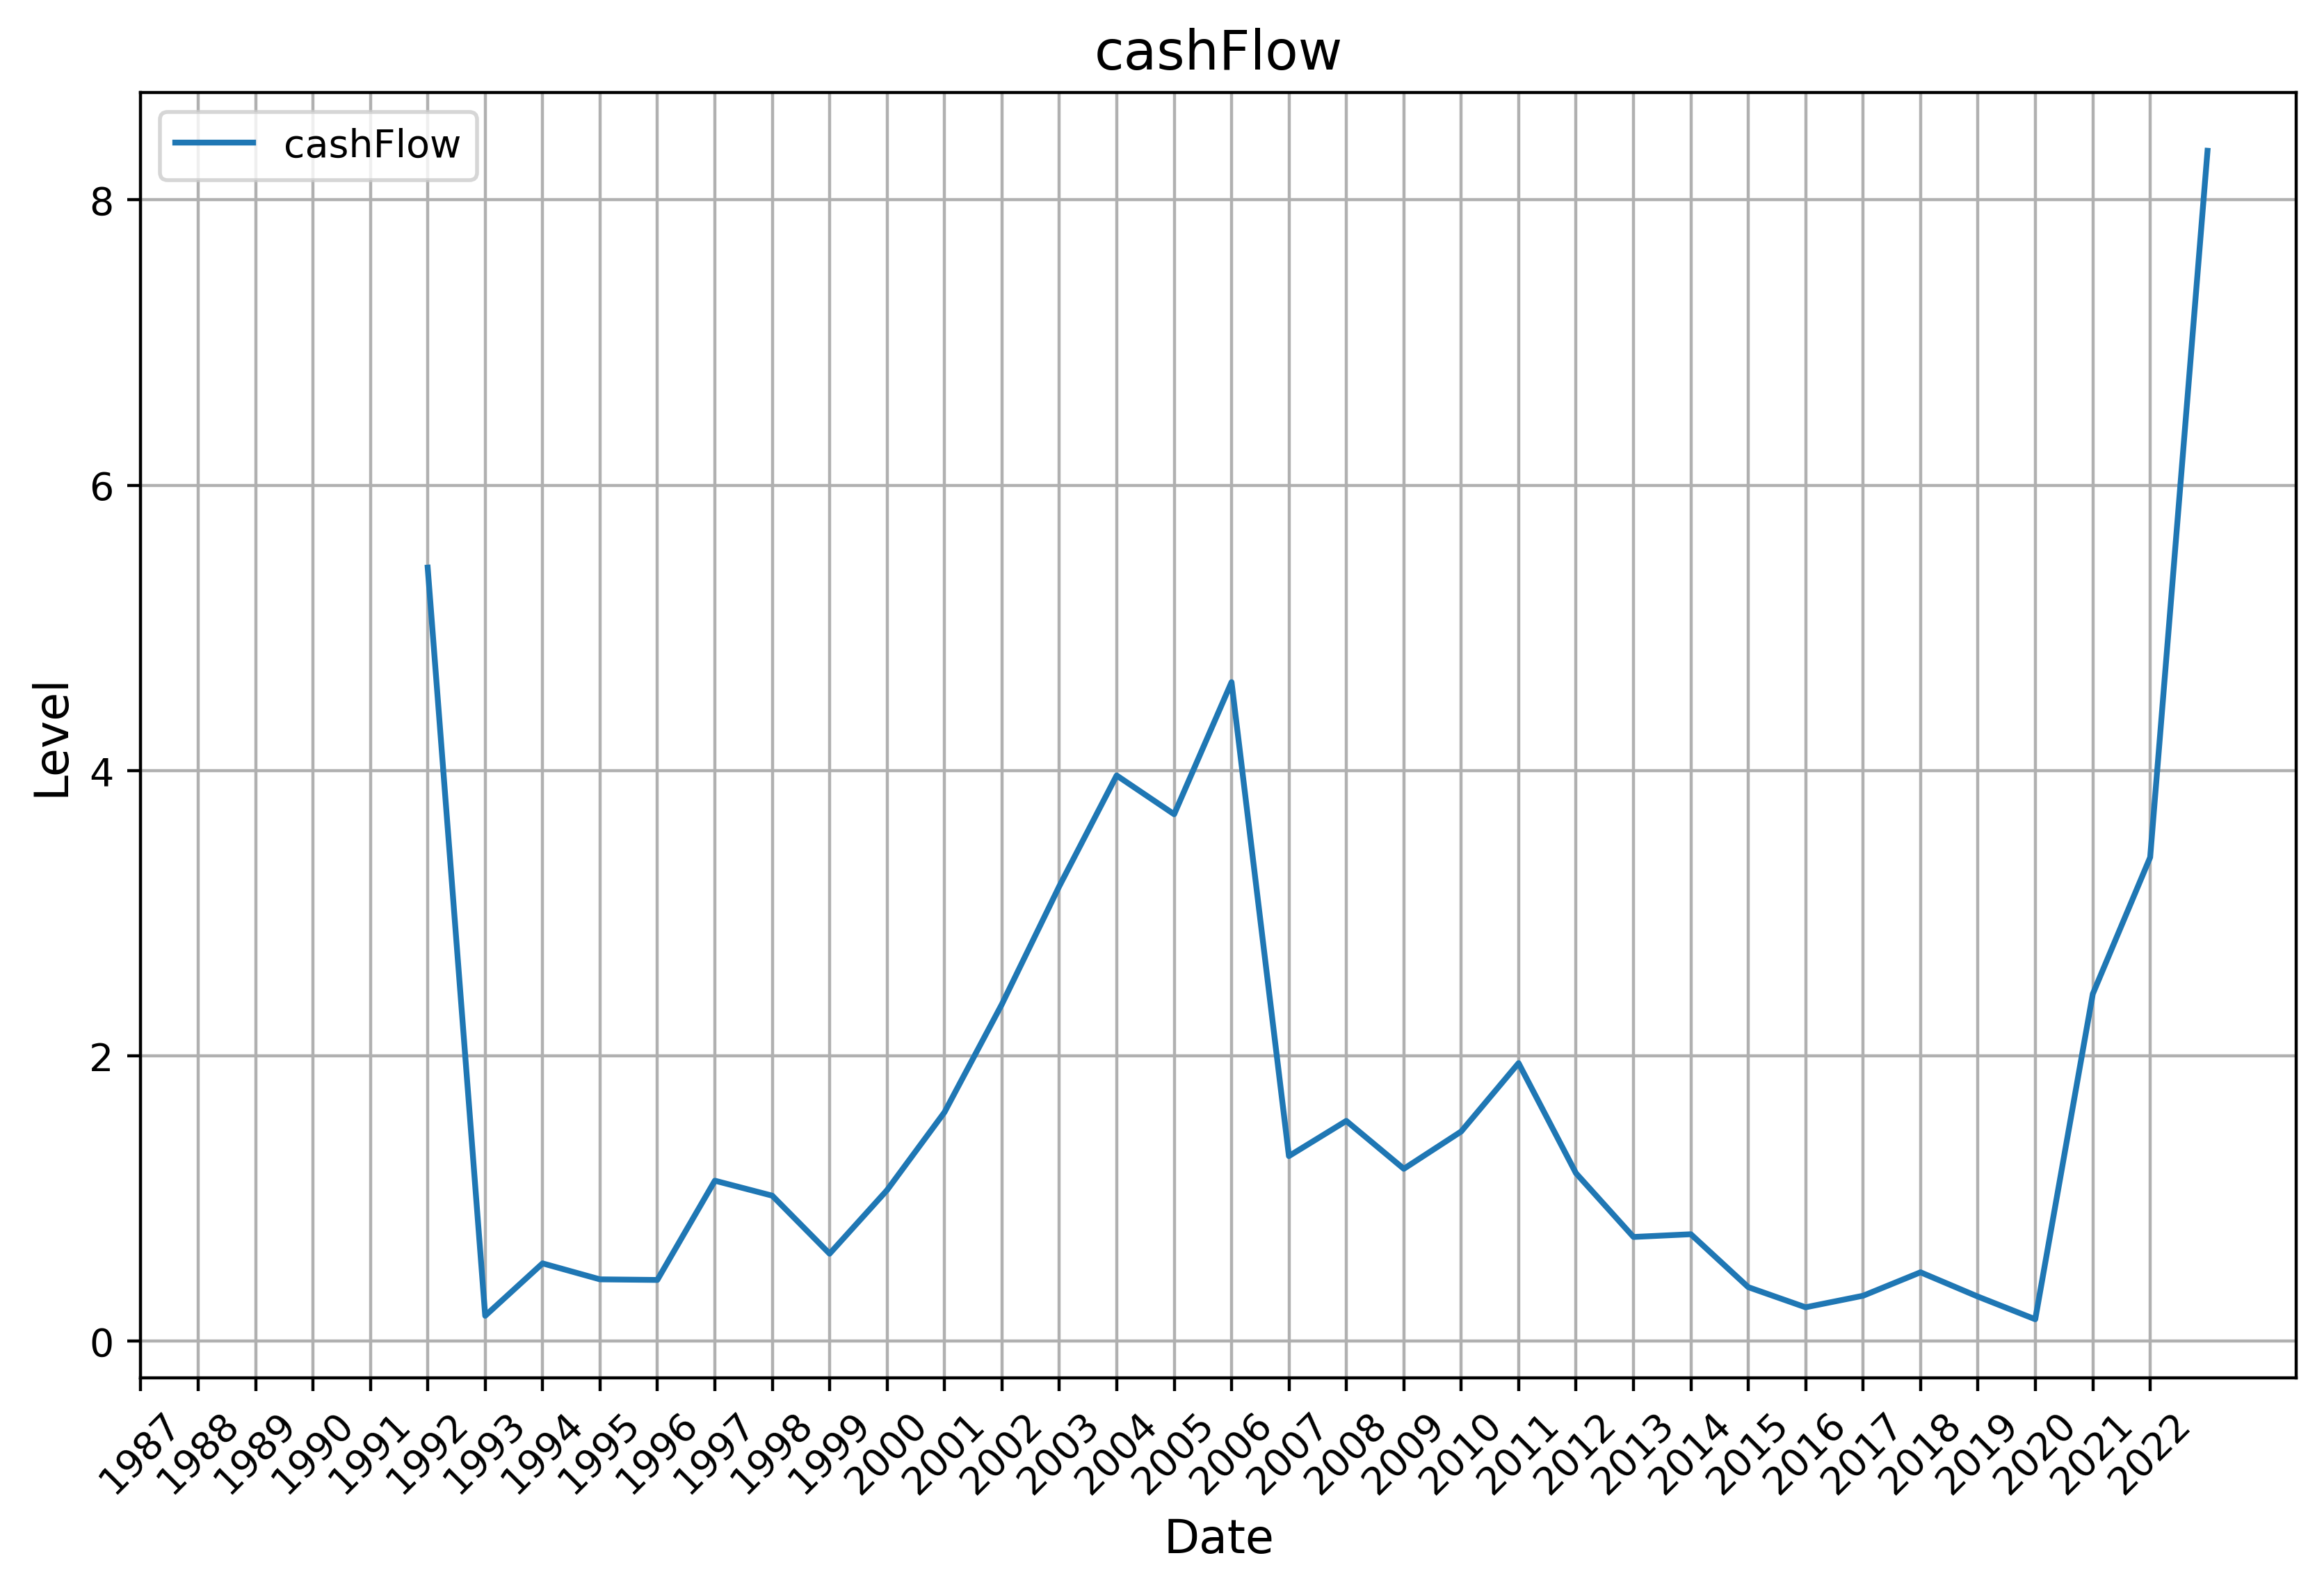

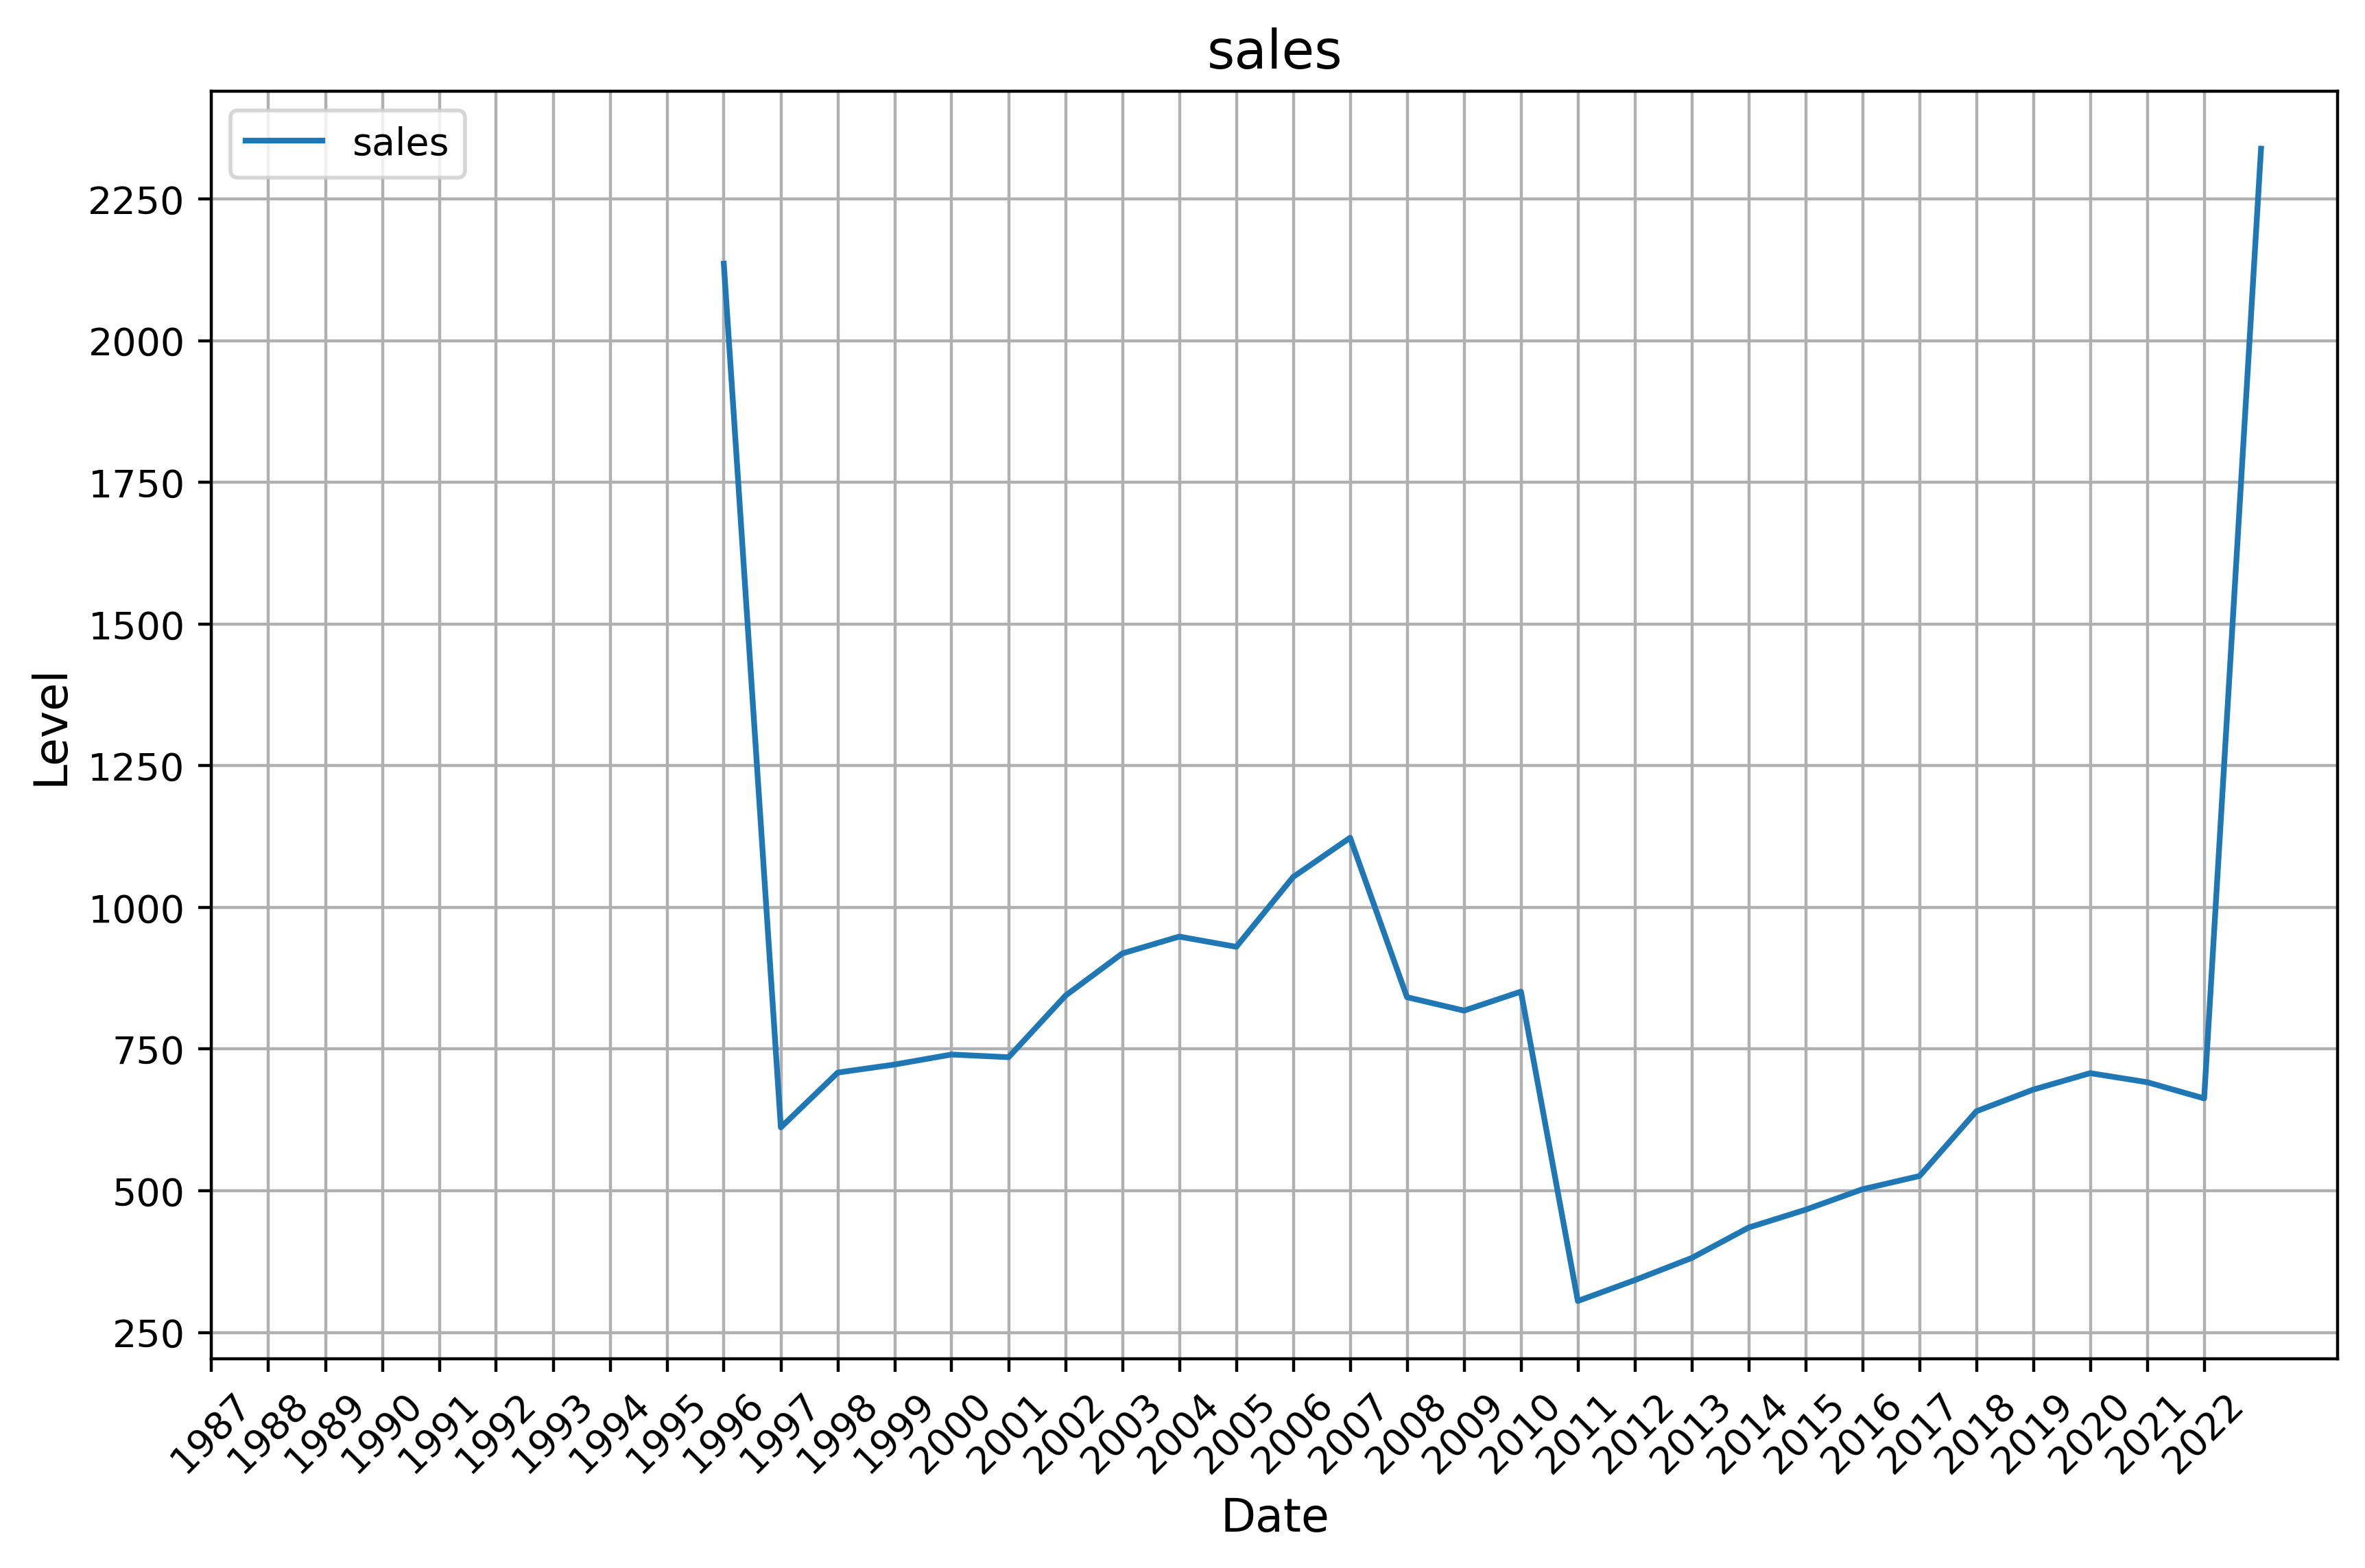

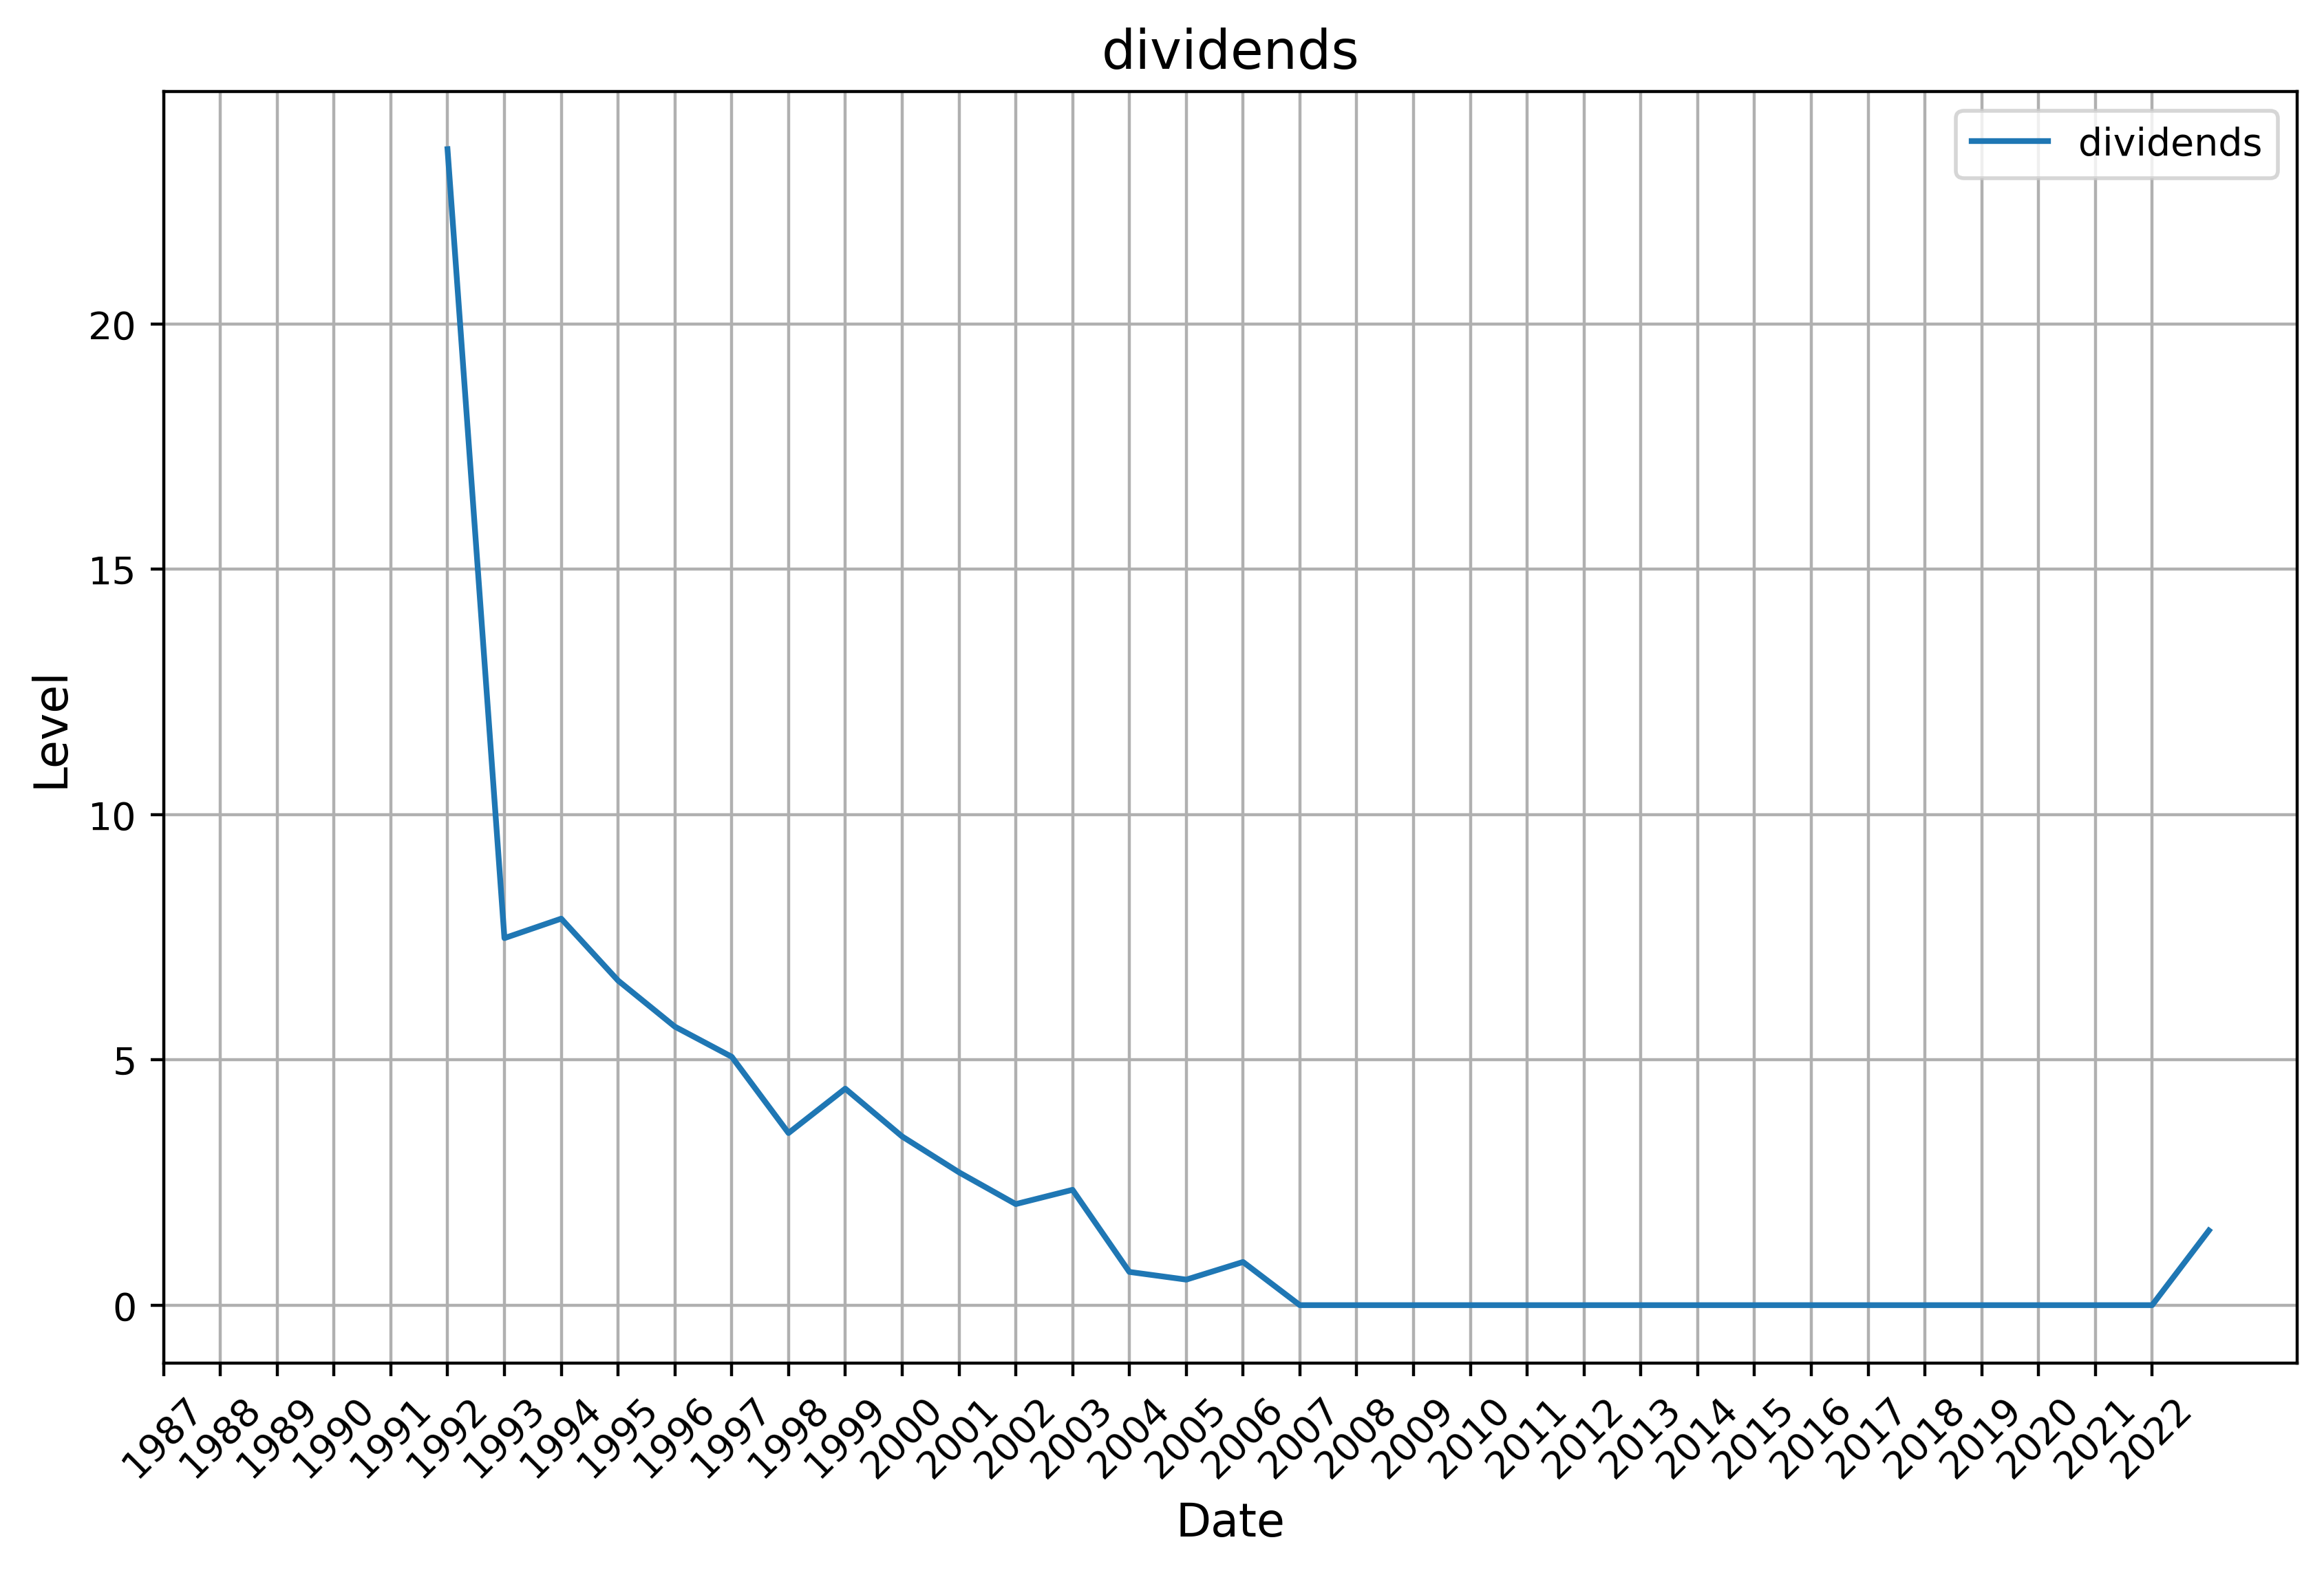

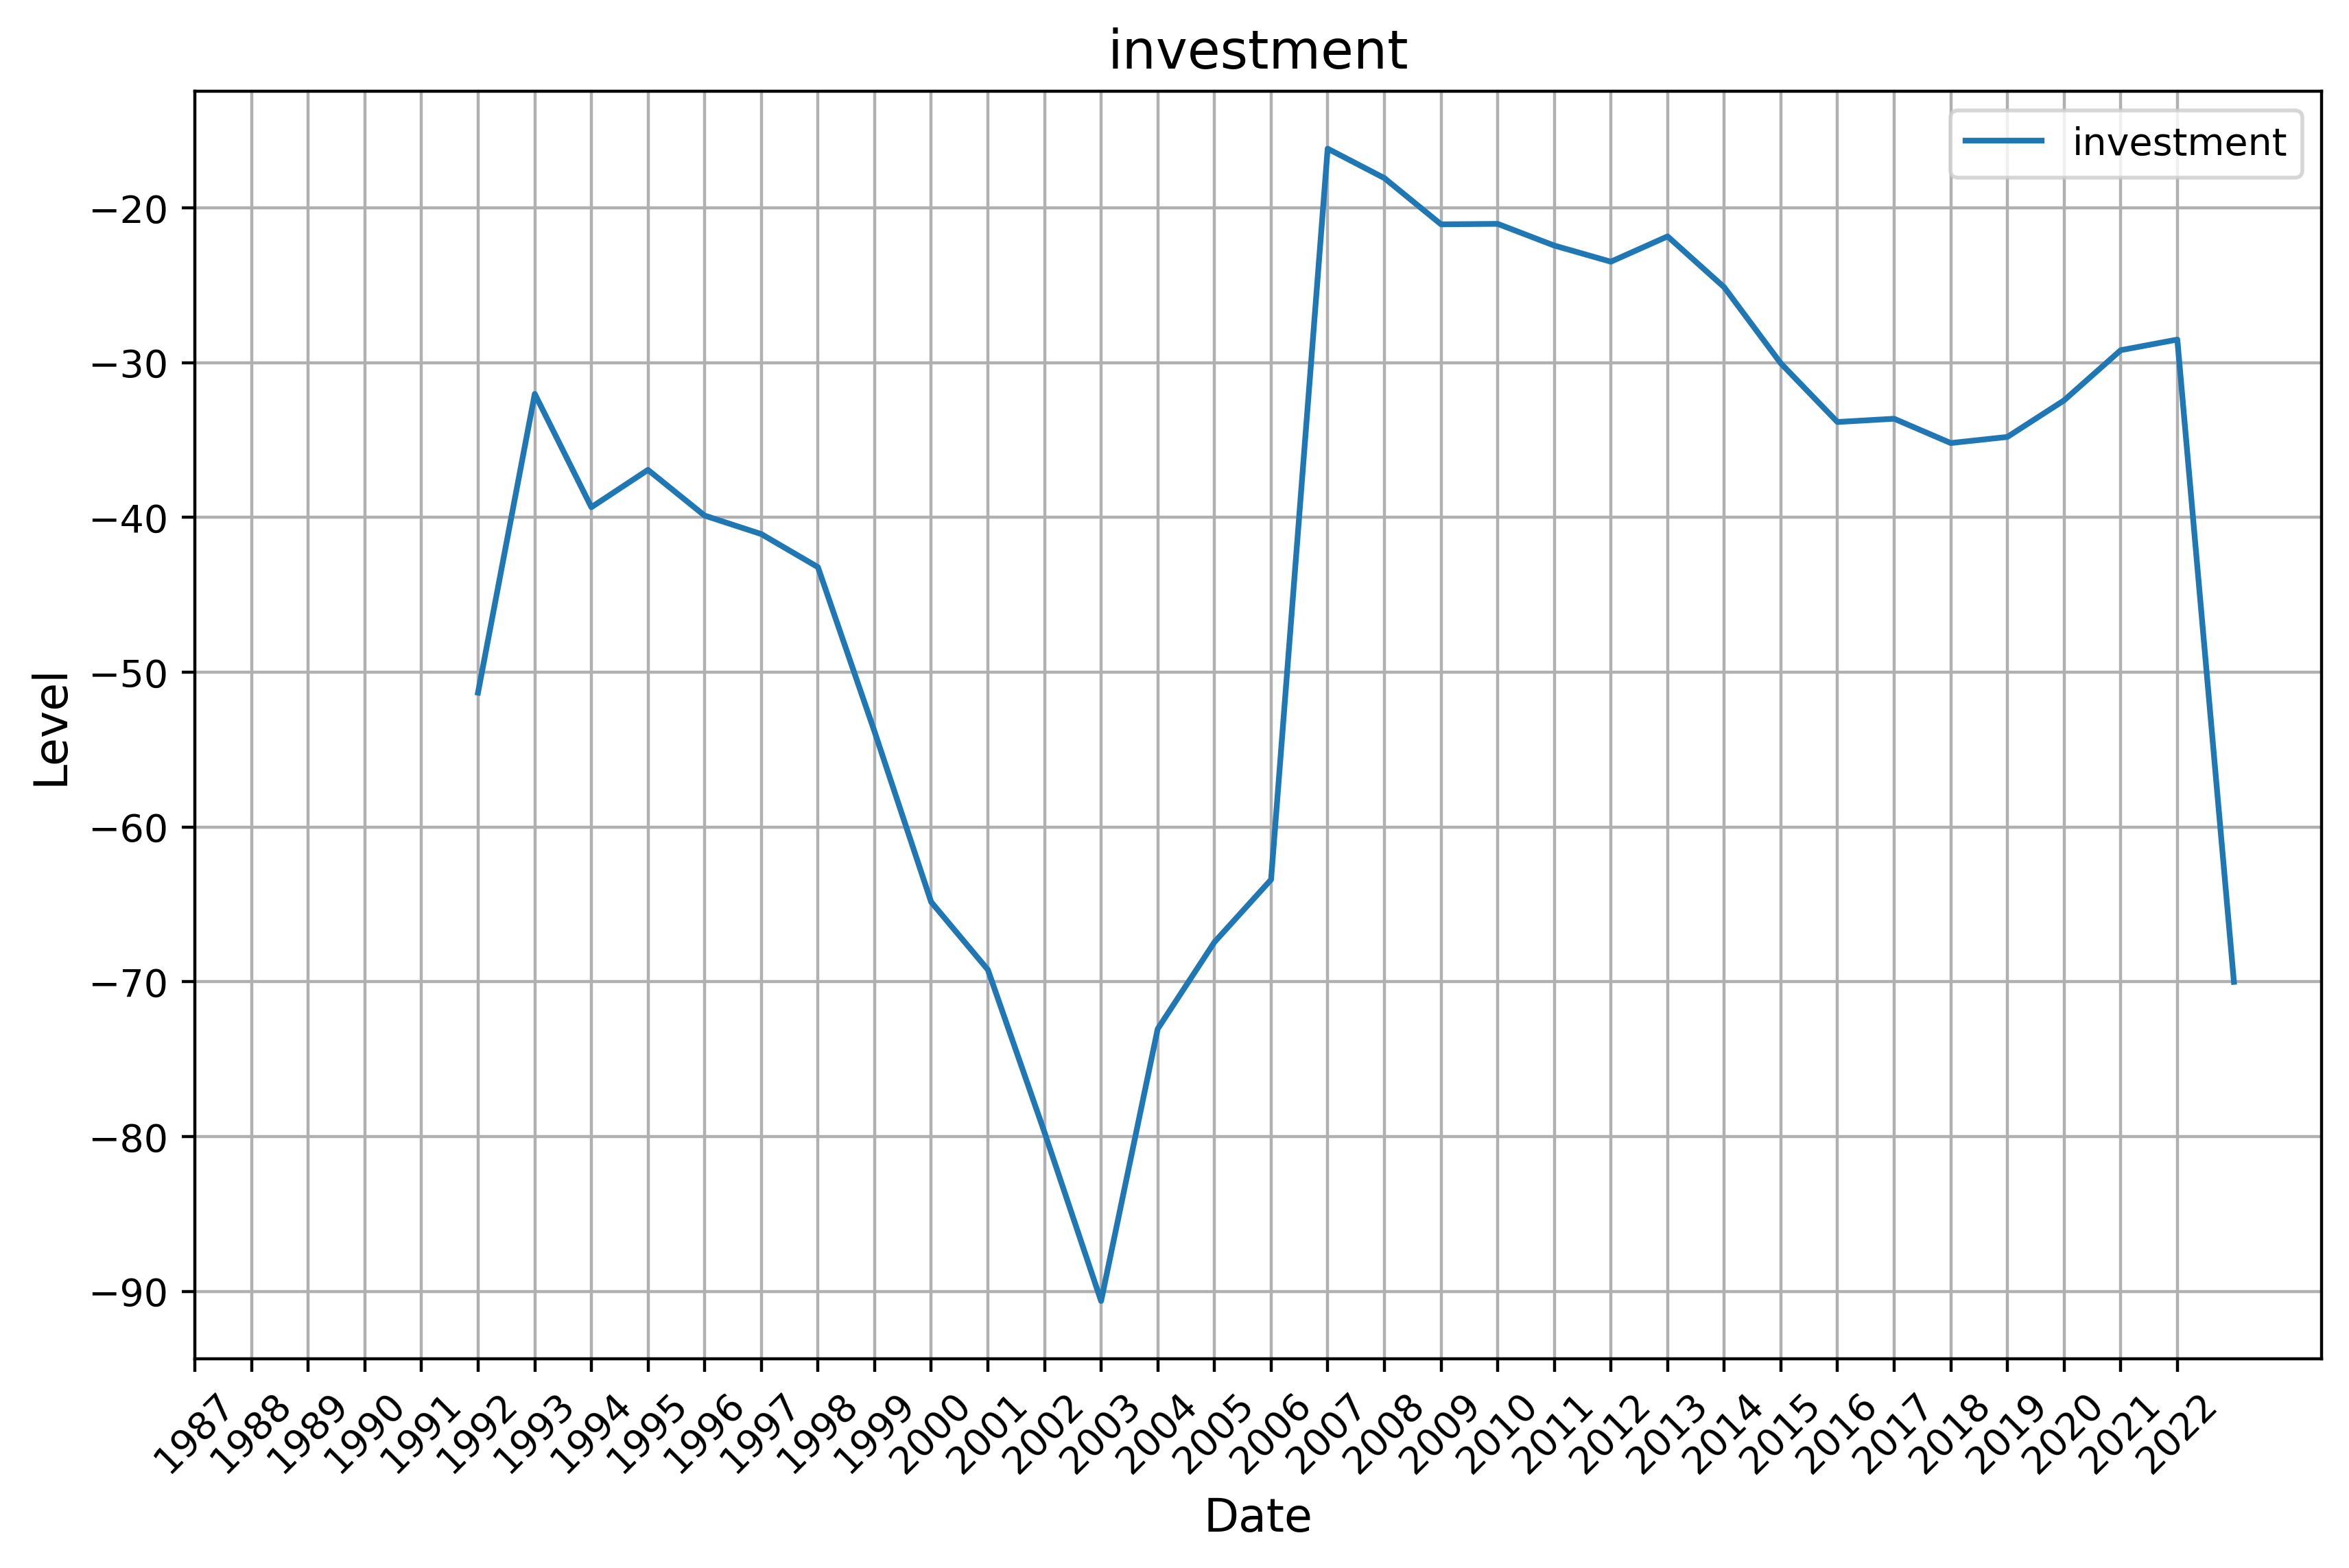

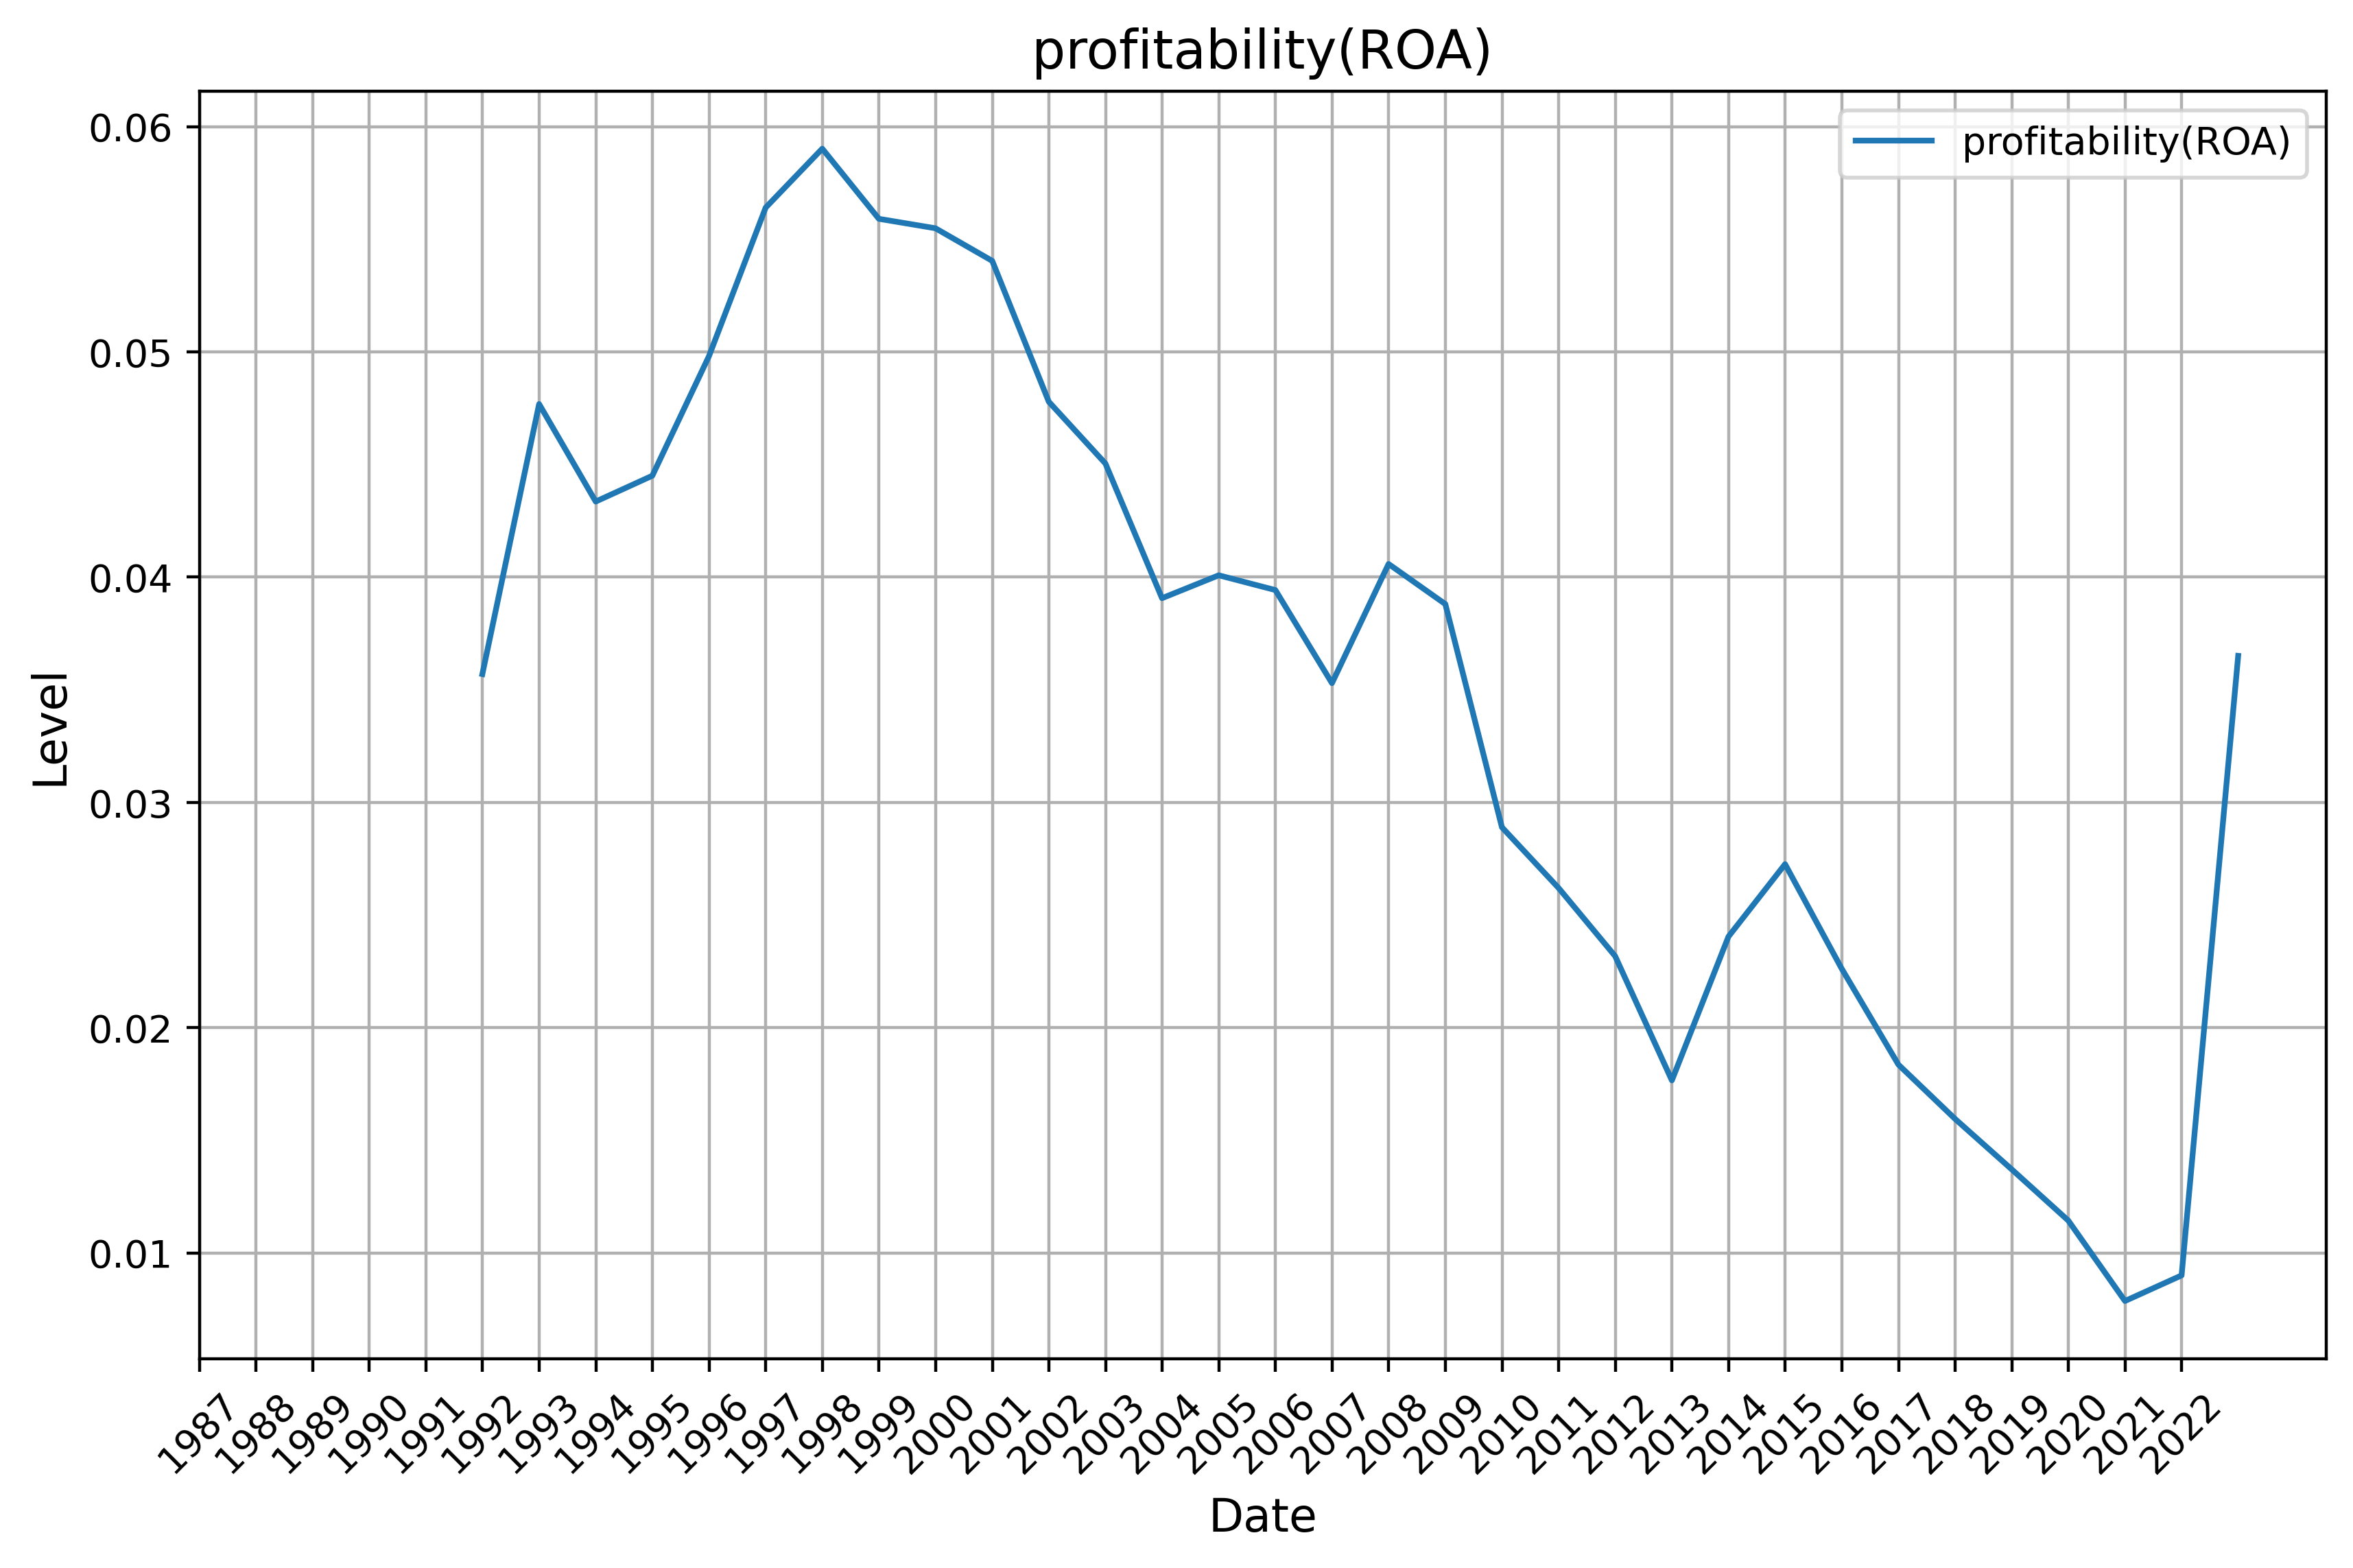

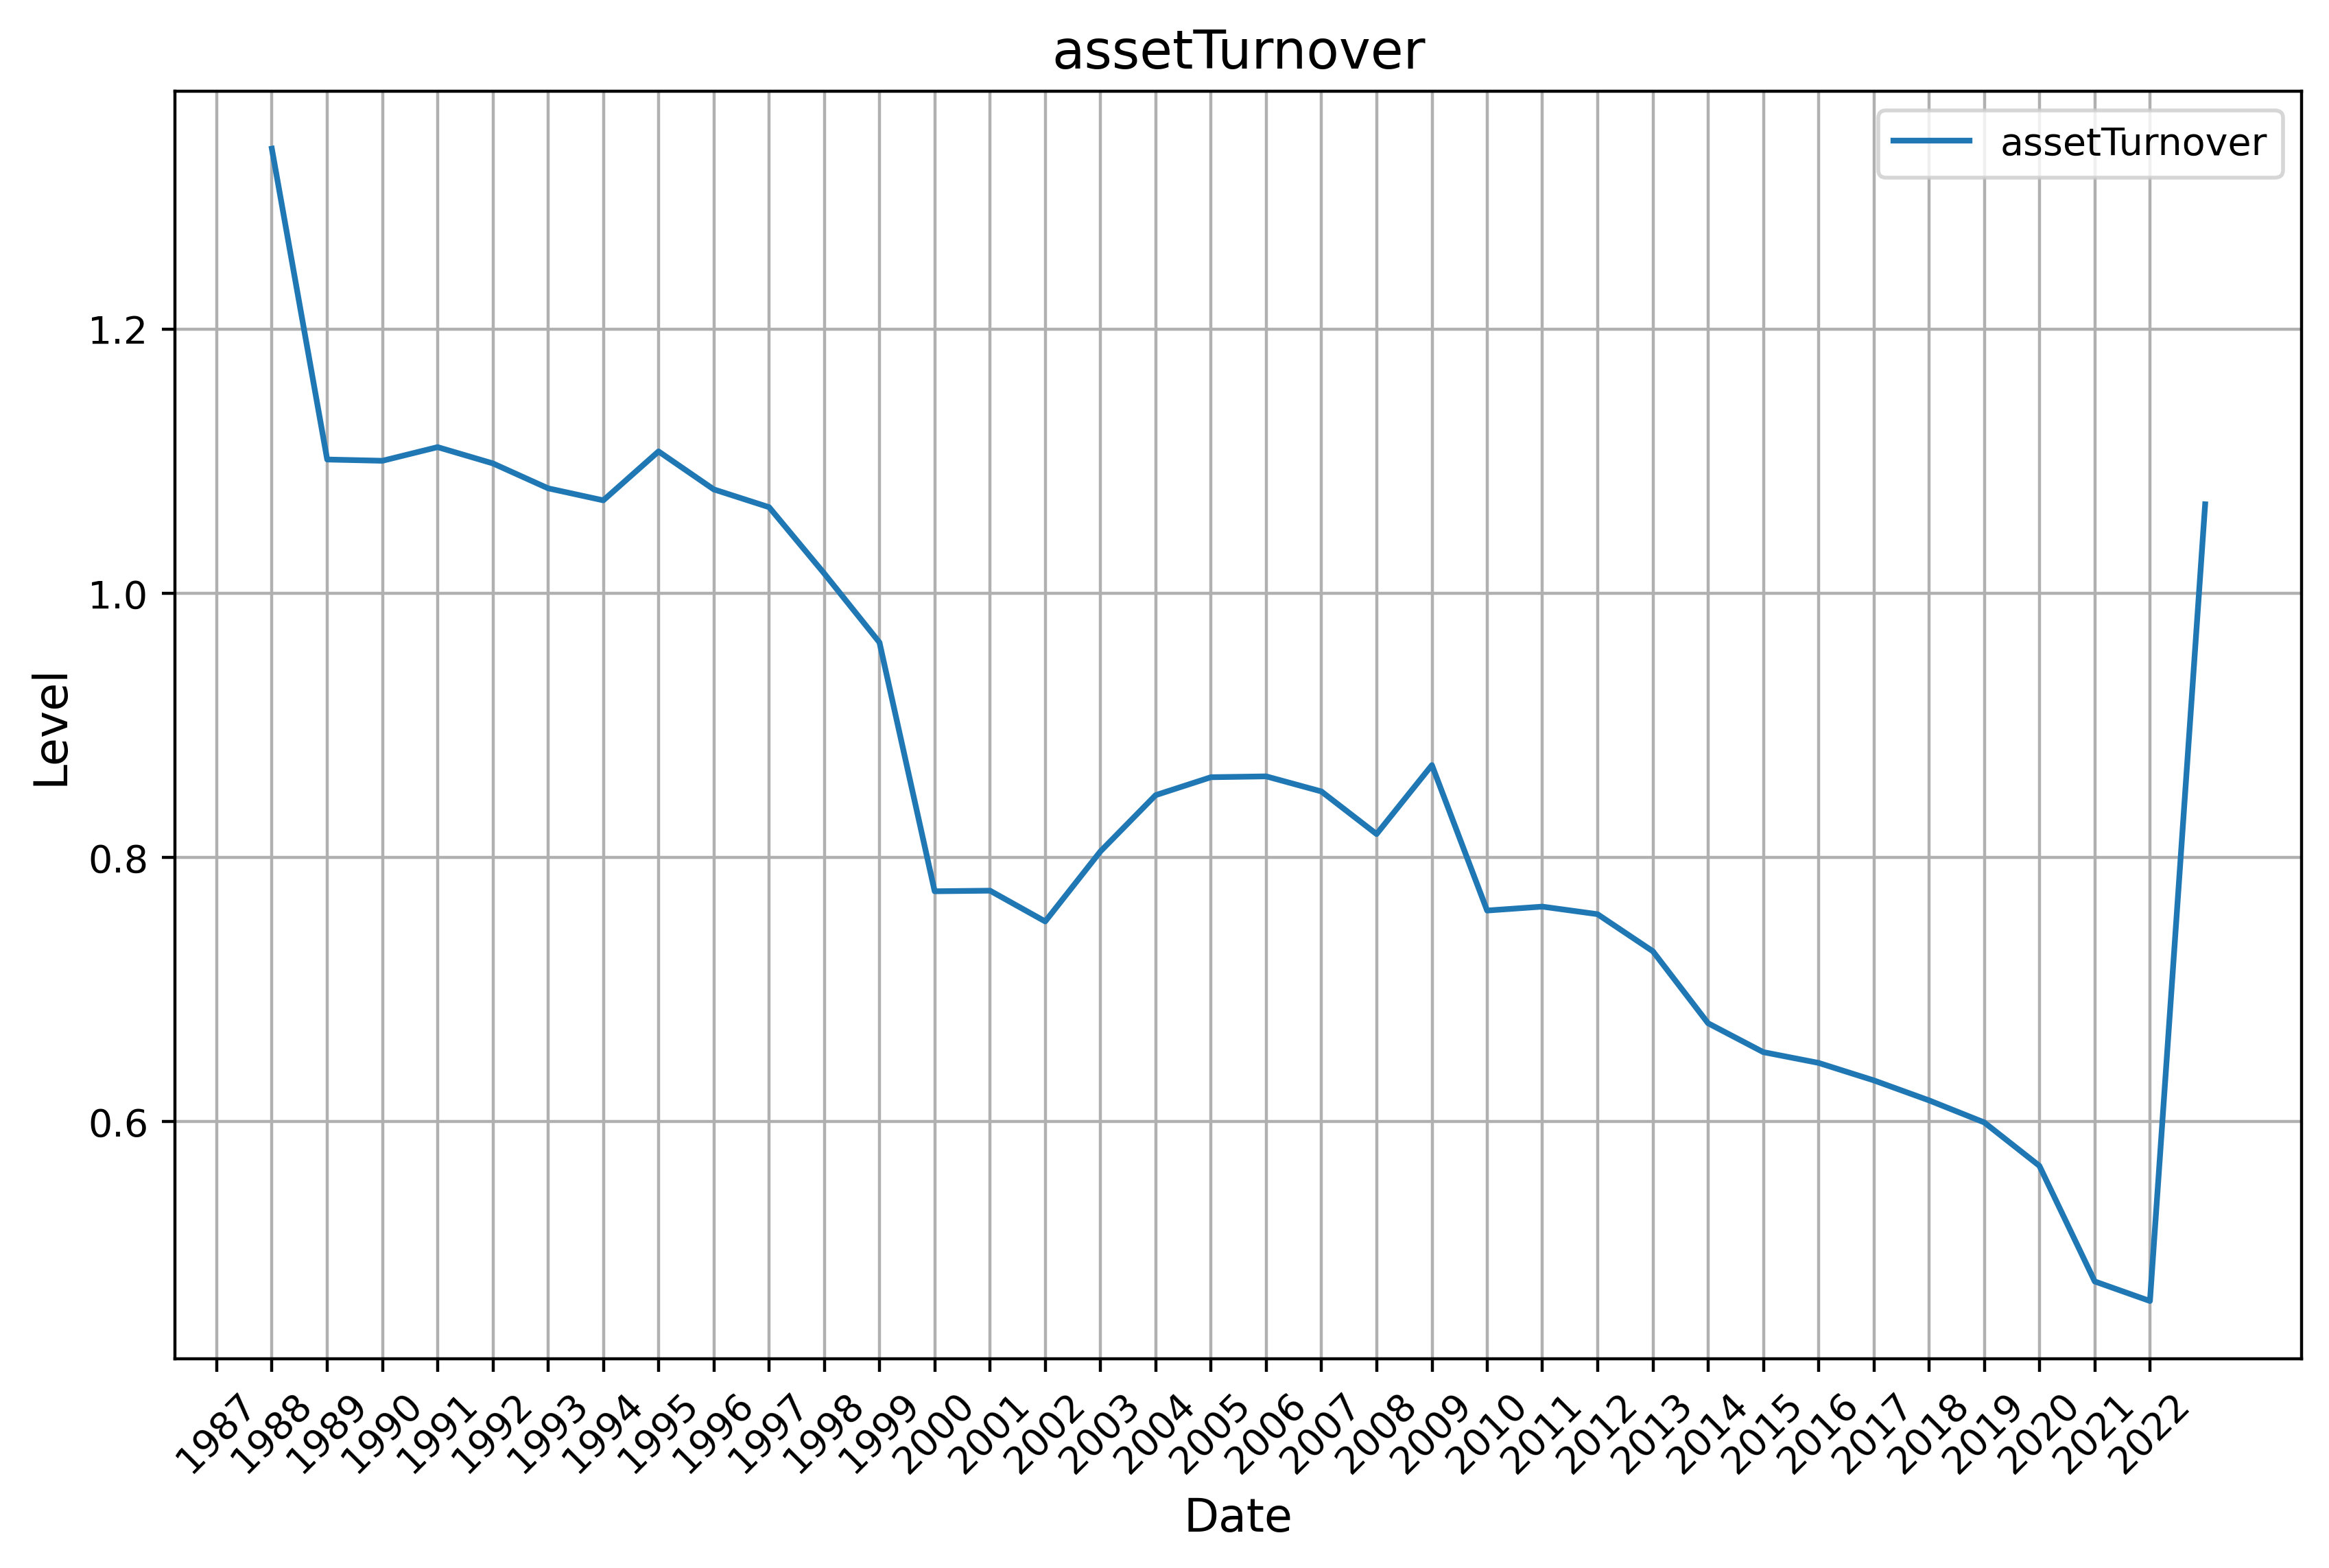

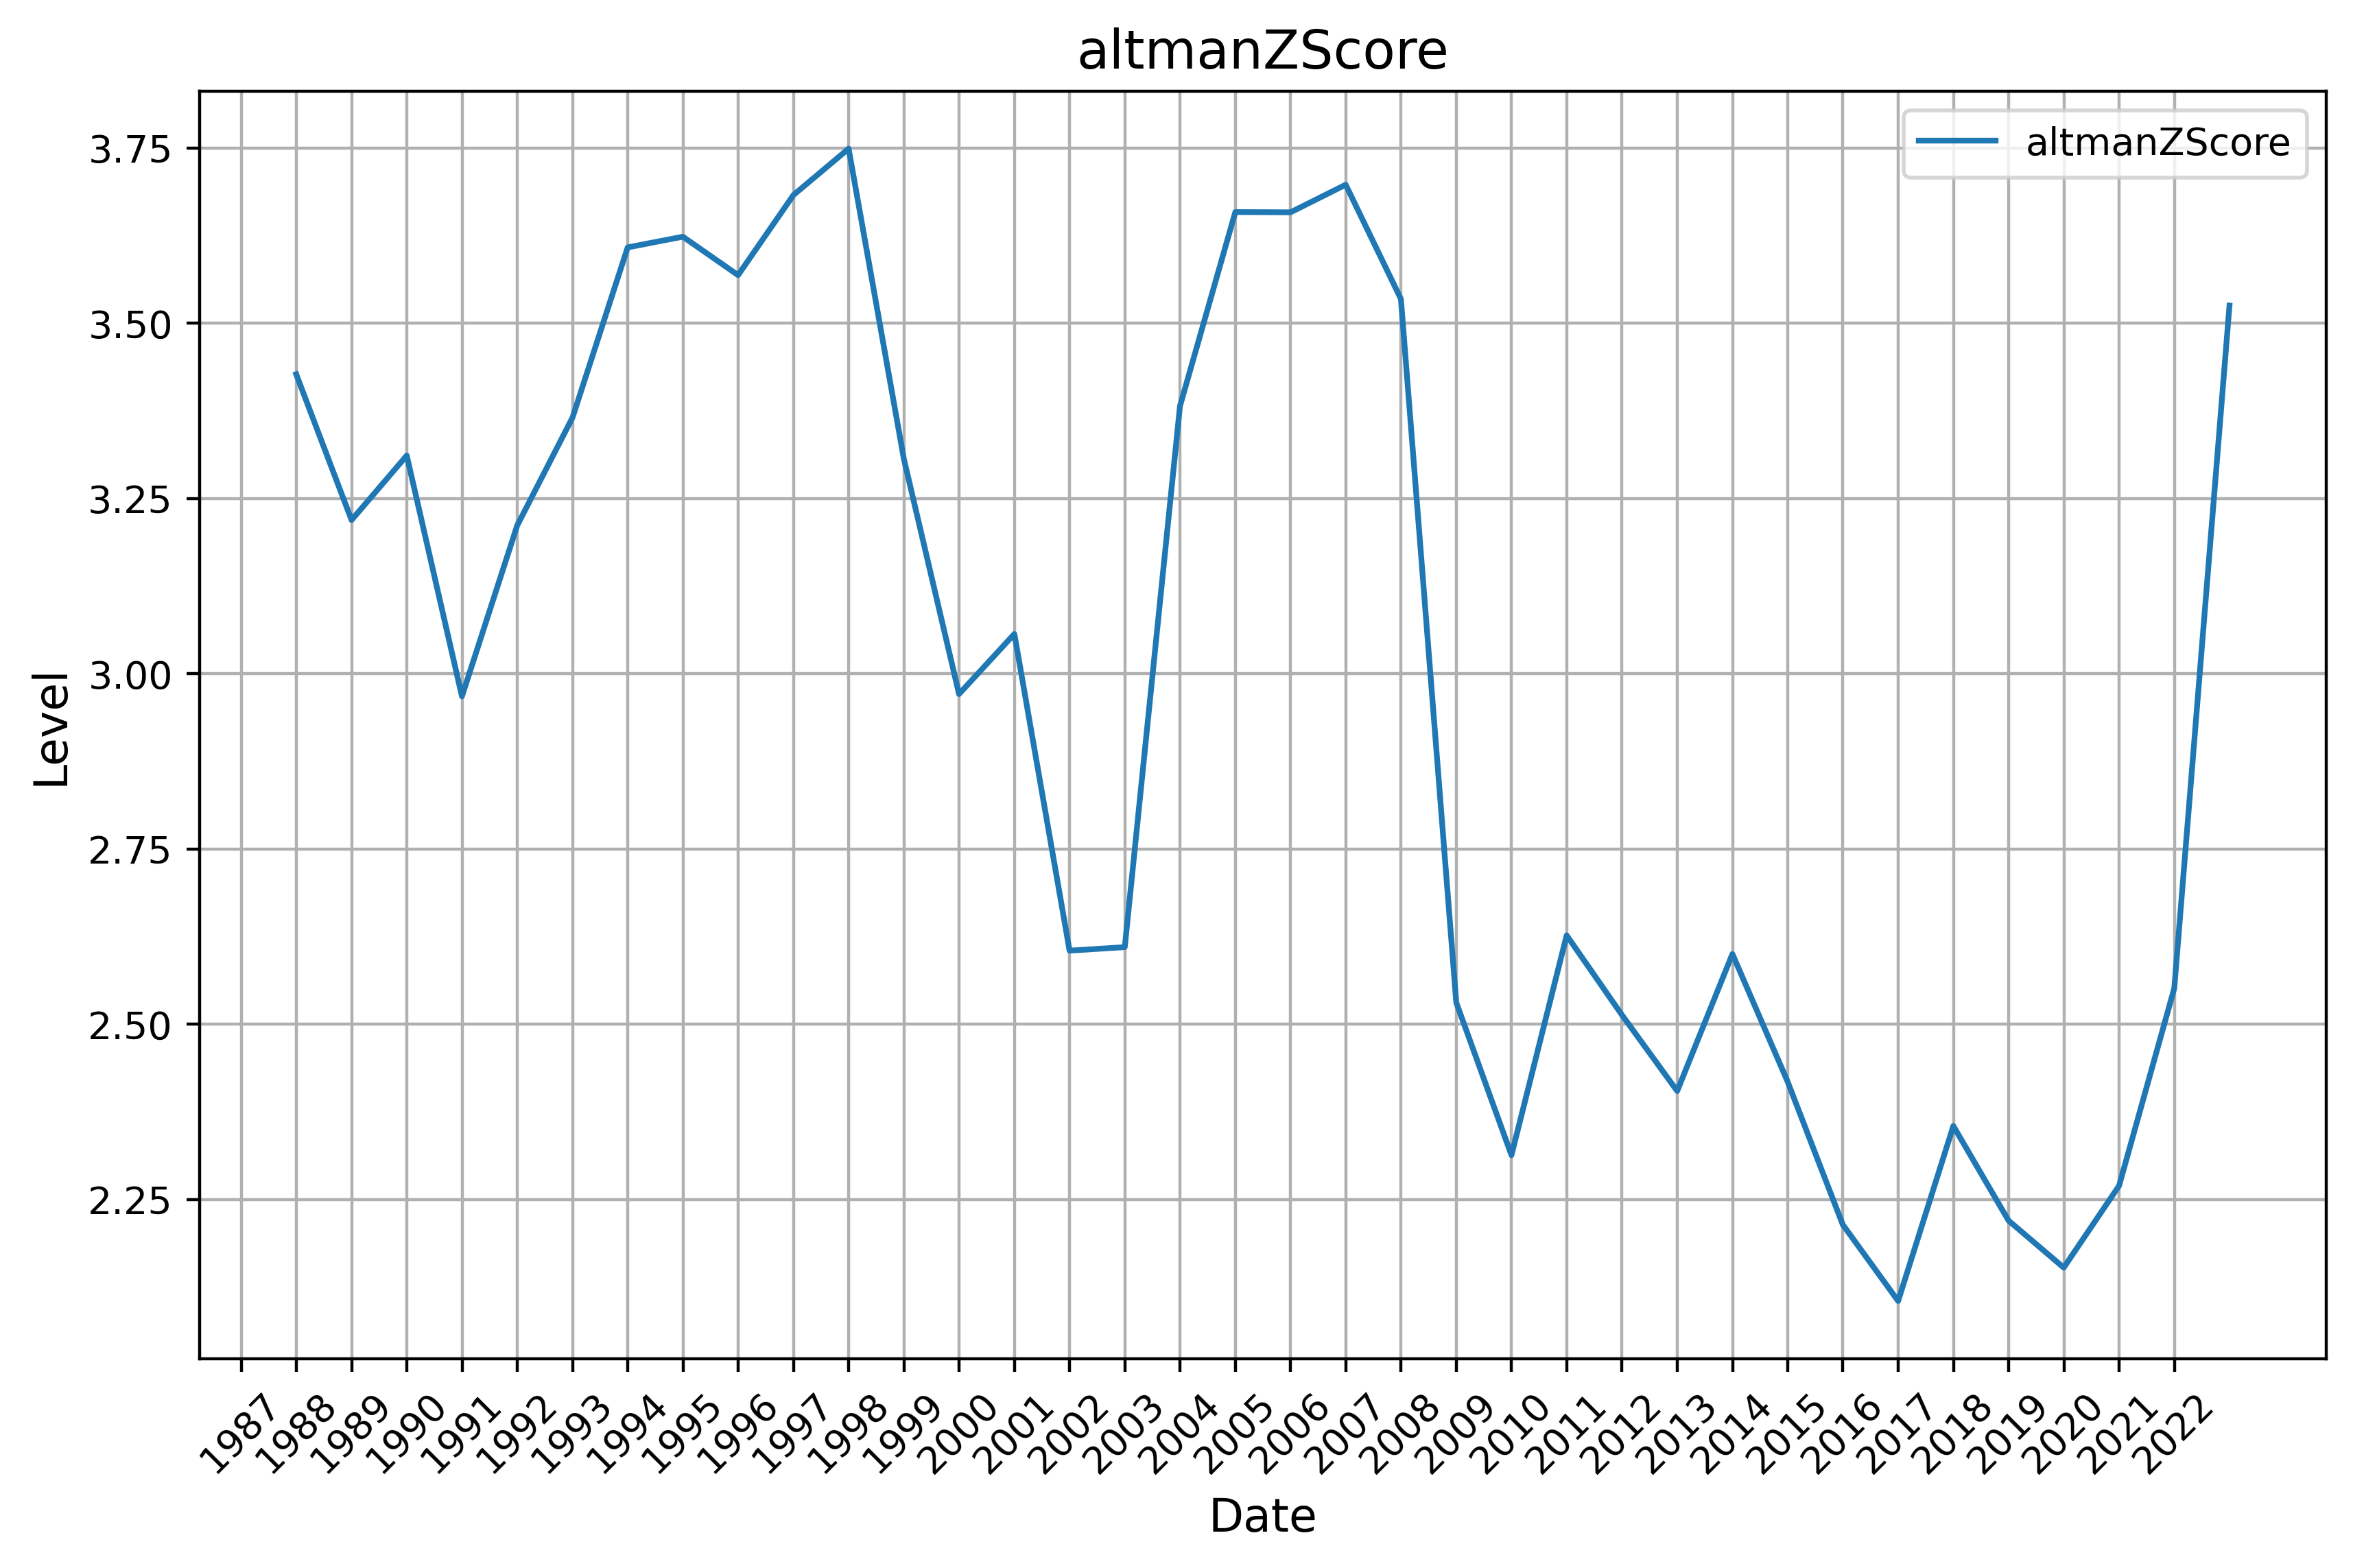

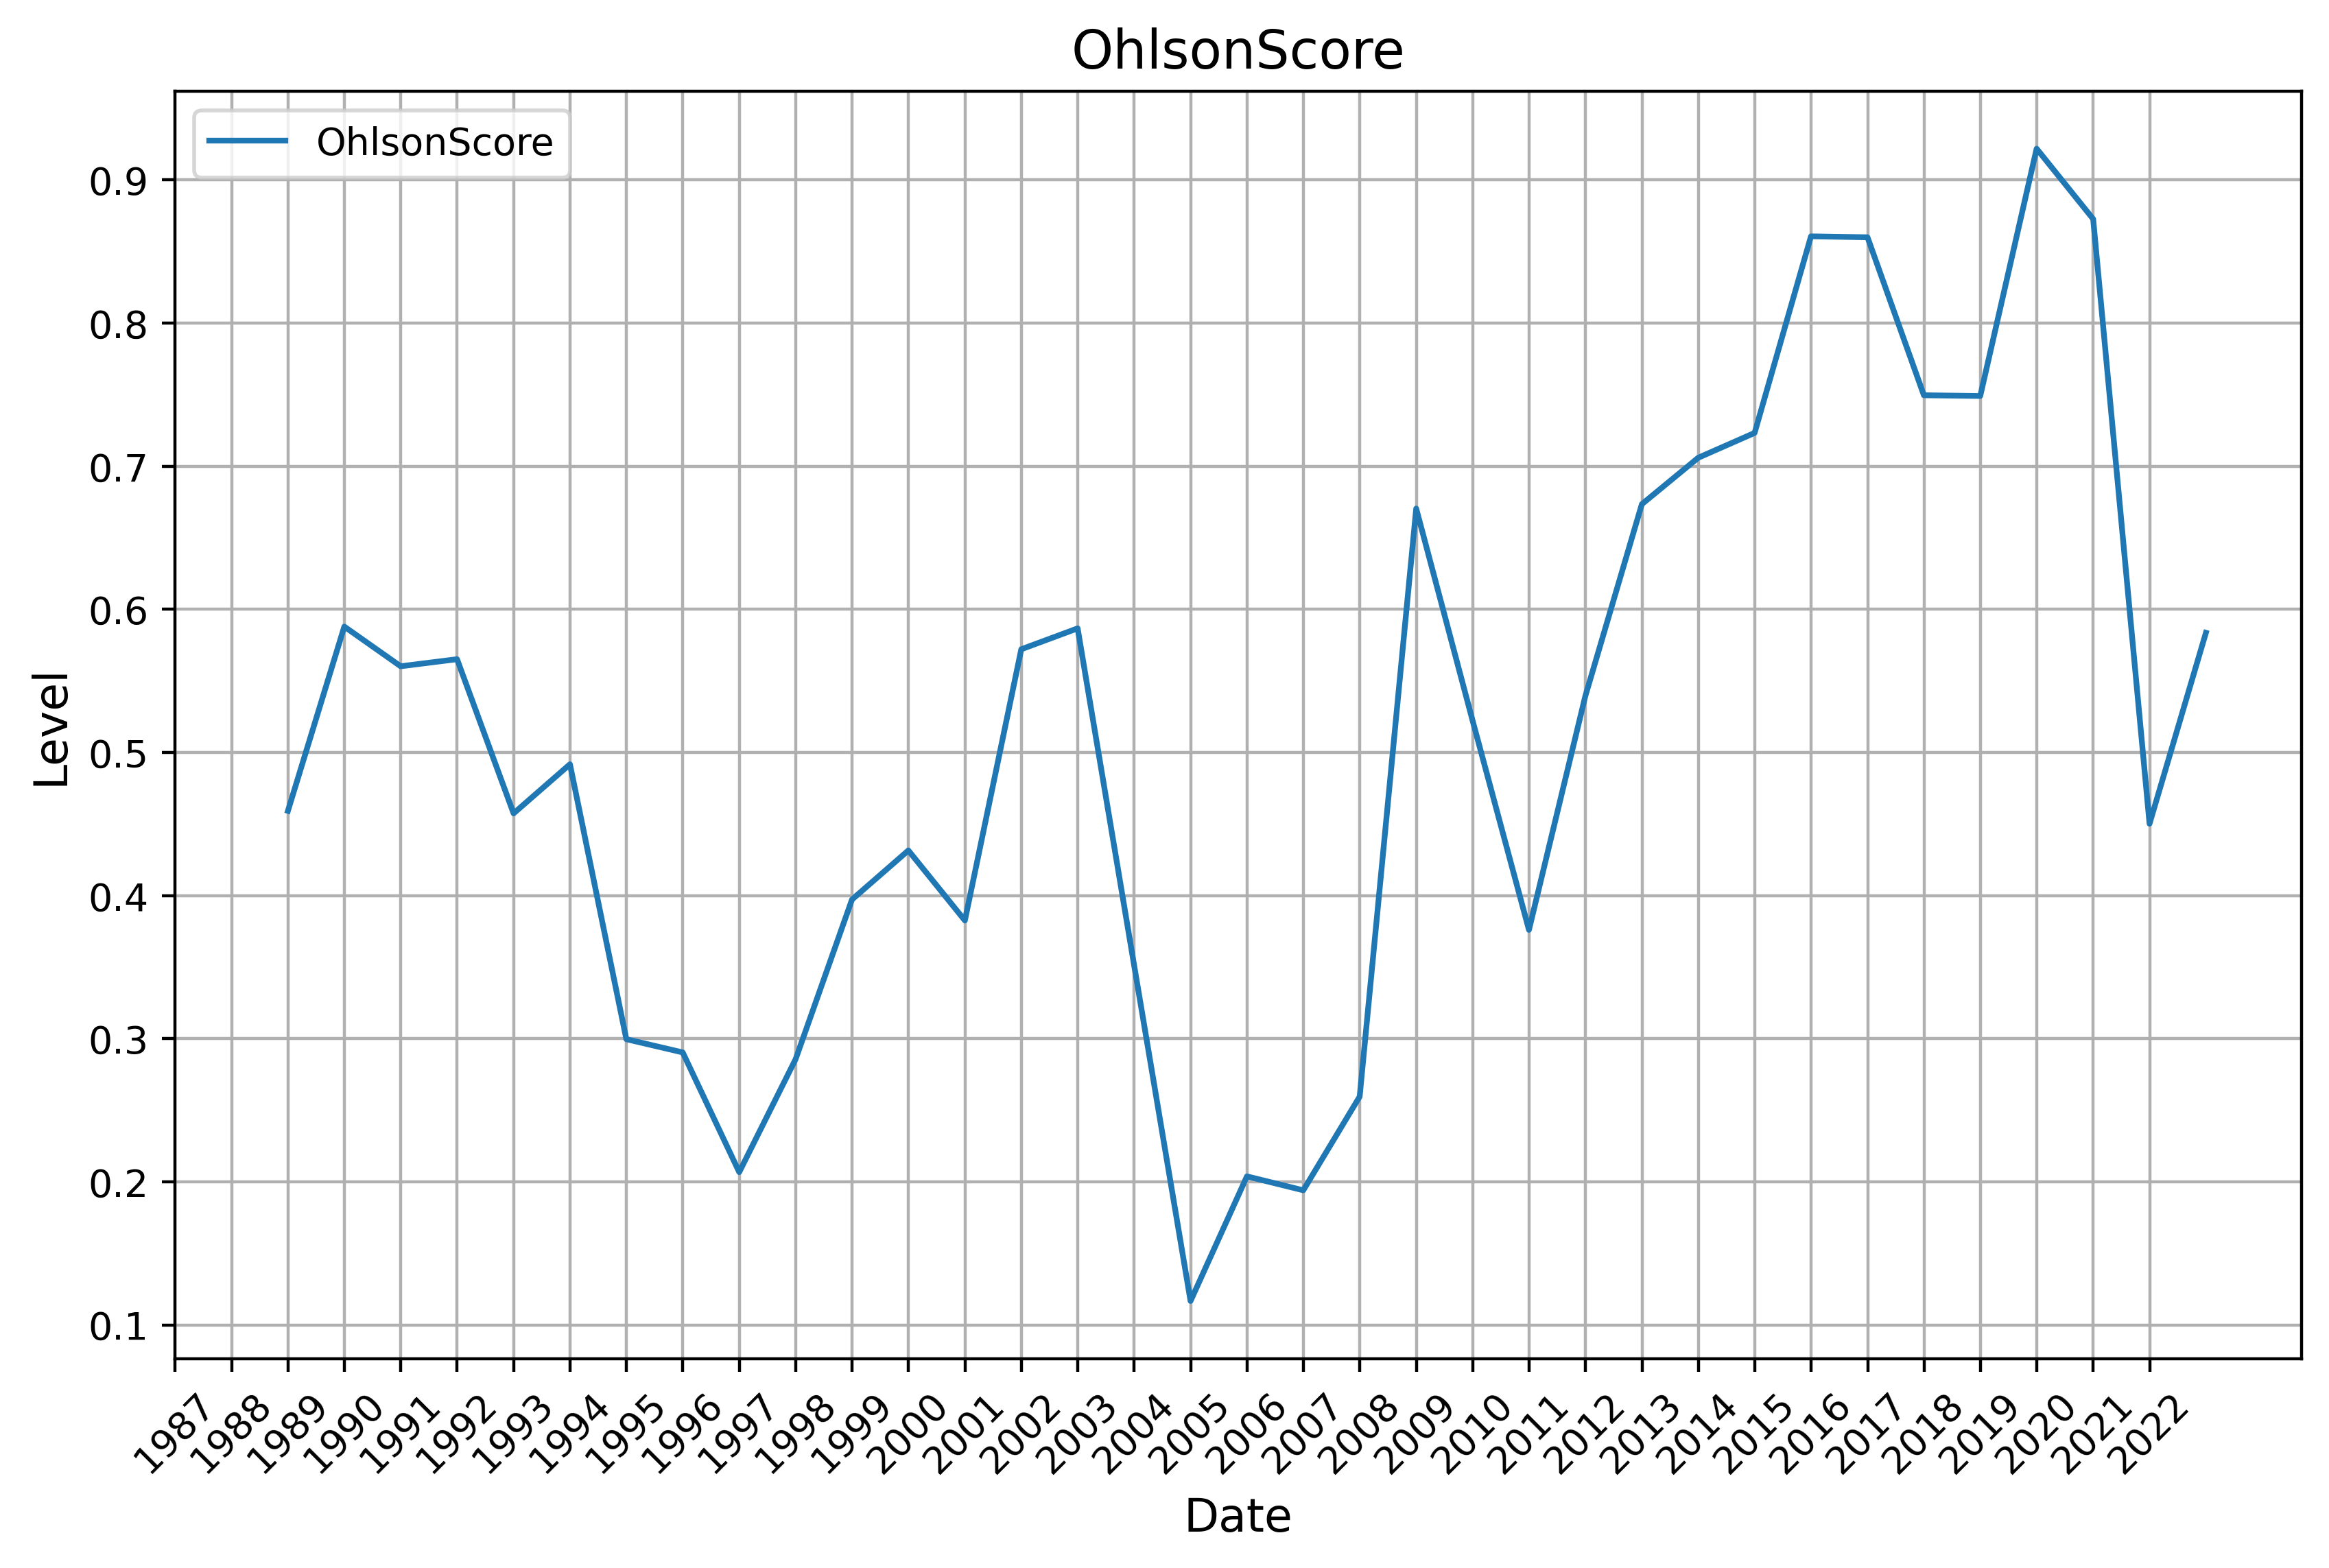

In [191]:
ts = compustatAnnual[["bookValue", "cashFlow", "sales", 
                                   "dividends", "investment", "assetTurnover",
                                   "profitability(ROA)", "altmanZScore",
                                   "at", "gnp", "lt", "act", "lct", "ni", "cusip"]]




start_time = time.time()
def compustatTS(group):
    df = group[1]
    df["cashFlow"] = df["cashFlow"].rolling(window = 5).mean()
    df["sales"] = df["sales"].rolling(window = 5).mean()
    df["sales"] = df["sales"].rolling(window = 5).mean()
    df["dividends"] = df["dividends"].rolling(window = 5).mean()
    df["investment"] = df["investment"].rolling(window = 5).mean()
    df["profitability(ROA)"] = df["profitability(ROA)"].rolling(window = 5).mean()  
    df['X'] = (df['lt'] > df['at']).astype(int)
    df["ni_t_1"] = df["ni"].shift(1)
    df['Y'] = (df['ni_t_1'] < 0).astype(int)
    df["OhlsonScore"] =-1.32\
        -0.407*np.log(df["at"])\
            + 0.407*np.log(df["gnp"])\
                +6.03*df["lt"]/df["at"]\
                    -1.43*(df["act"] - df["lct"])/df["at"] \
                        +0.0757*df["lct"]/df["act"] \
                            -1.72*df["X"] \
                                -2.37*df["ni"]/df["at"] \
                                    -.285*df["Y"]\
                                        -0.521*(df["ni"]- df["ni_t_1"])/(abs(df["ni"]) + abs(df["ni_t_1"]))
                                
    

    

    return df


compustatGrouped = list(ts.groupby("cusip"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(compustatTS, compustatGrouped))
ts = pd.concat(results)
ts = ts[["bookValue", "cashFlow", "sales", 
        "dividends", "investment", "profitability(ROA)",
        "assetTurnover", "altmanZScore", "OhlsonScore"]]
ts = ts.groupby(ts.index).median()
elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))


for col in list(ts.columns):
    plotSeriesFromDataFrame(ts[[col]], title=col, xLabel='Date', yLabel='Level', 
                                legendLoc='best', fileName=None, rotateXTicks = True,
                               legendOutside = False)



### 5. & 6. Beta, Total Volatility and Annualized Volatility,
### Residual Standard Error for CAPM, Fama French and Fama French + Momentum
### Idiosyncratic Volatility

In [192]:
def beta(df, timeWindow, freq = "daily", winsorized = False):
    if freq == "monthly":
        df = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    if winsorized:
        Y = df["winsorizedRET"].tail(timeWindow)        
    else:
        Y = df["RET"].tail(timeWindow)
    X = df["vwretd"].tail(timeWindow)
    X = sm.add_constant(X)
    
    if len(X) < 2 or X["vwretd"].var() == 0 or Y.var() == 0:
        return None
    model = sm.OLS(Y, X).fit()
    try:
        return model.params[1]
    except IndexError:
        return None    

def regressionCAPM(m):
    
    m = m.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    X = m[['vwretd']]
    y = m['RET']
    
    if len(X) < 2  or y.var() == 0:
        return None

    model = sm.OLS(y, X).fit()
    RSE_CAPM = model.resid.std(ddof = 2)
    return RSE_CAPM


def regressionFamaFrech(m):
    
    m = m.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    X = m[['vwretd', 'SMB', 'HML']]
    y = m['RET']
    
    if len(X) < 2  or y.var() == 0:
        return None

    model = sm.OLS(y, X).fit()
    RSE_FAMA_FRENCH = model.resid.std(ddof = 4)
    return RSE_FAMA_FRENCH



def regressionFamaFrenchMomentum(m):
    
    m = m.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    X = m[['vwretd', 'SMB', 'HML', 'Mom']]
    y = m['RET']
    
    if len(X) < 2  or y.var() == 0:
        return None

    model = sm.OLS(y, X).fit()
    RSE_FAMA_FRENCH_MOMENTUM = model.resid.std(ddof = 5)
    return RSE_FAMA_FRENCH_MOMENTUM



    
    
def monthlyBetaTask(companyData):
    cusip, df = companyData
    years = df.index.year.unique()
    result = []
    for year in years:
        yearly = df[df.index.year.isin([year, year-1])].sort_index()
        yearly = yearly.dropna().replace([np.inf, -np.inf], np.nan).dropna()
        RSE_CAPM = regressionCAPM(yearly)
        RSE_FAMA_FRENCH = regressionFamaFrech(yearly)
        RSE_FAMA_FRENCH_MOMENTUM = regressionFamaFrenchMomentum(yearly)
        if RSE_CAPM:
            IdioVolatility_CAPM = 100*RSE_CAPM*np.sqrt(12)
        else:
            IdioVolatility_CAPM = None

        if RSE_FAMA_FRENCH:
            IdioVolatility_FAMA_FRENCH = 100*RSE_FAMA_FRENCH*np.sqrt(12)
        else:
            IdioVolatility_FAMA_FRENCH = None

        if RSE_FAMA_FRENCH_MOMENTUM:
            IdioVolatility_FAMA_FRENCH_MOMENTUM = 100*RSE_FAMA_FRENCH_MOMENTUM*np.sqrt(12)
        else:
            IdioVolatility_FAMA_FRENCH_MOMENTUM = None

        result.append({
            "cusip": cusip,
            "year": year,
            "beta": beta(yearly, 12, freq = "monthly"),
            "volatility": 100*yearly["RET"].std(),
            "annualizedVolatility": 100*yearly["RET"].std()*np.sqrt(12),
            "annualizedVolatilityCentered": 100*np.sqrt(yearly["RET"].std() + np.square(yearly["RET"].mean())),
            "RSE_CAPM": RSE_CAPM,
            "RSE_FAMA_FRENCH": RSE_FAMA_FRENCH,
            "RSE_FAMA_FRENCH_MOMENTUM": RSE_FAMA_FRENCH_MOMENTUM,
            "IdioVolatility_CAPM": IdioVolatility_CAPM,
            "IdioVolatility_FAMA_FRENCH": IdioVolatility_FAMA_FRENCH,
            "IdioVolatility_FAMA_FRENCH_MOMENTUM": IdioVolatility_FAMA_FRENCH_MOMENTUM
            })
    return result

In [193]:
start_time = time.time()
crsp = crsp.merge(factorData, left_index = True, right_index = True, how = "left")
crsp = crsp.rename(columns = {"Mom   ": "Mom"})
monthlyGrouped = list(crsp.groupby("cusip"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(monthlyBetaTask, monthlyGrouped))
elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))


results = [item for sublist in results for item in sublist]
results = pd.DataFrame(results)
results = results.drop(columns = ["cusip"])
descStats = descriptiveStats(results)    
descStats = descStats.drop(["year"])
display(descStats)    

This took 18 minutes 50 seconds


N   mean    std      min     p1  \
beta                                 326190.0   1.13  11.75 -1551.53  -3.22   
volatility                           326311.0  14.50  10.92     0.00   2.94   
annualizedVolatility                 326311.0  50.24  37.84     0.00  10.17   
annualizedVolatilityCentered         326311.0  36.50  11.81     0.00  17.28   
RSE_CAPM                             324381.0   0.13   0.11     0.00   0.03   
RSE_FAMA_FRENCH                      319063.0   0.13   0.11     0.00   0.03   
RSE_FAMA_FRENCH_MOMENTUM             316590.0   0.13   0.11     0.00   0.03   
IdioVolatility_CAPM                  324381.0  46.30  37.28     0.05   9.56   
IdioVolatility_FAMA_FRENCH           319063.0  46.41  37.19     0.37   9.73   
IdioVolatility_FAMA_FRENCH_MOMENTUM  316590.0  46.31  37.17     0.24   9.74   

                                        p5    p25    p50    p75     p95  \
beta                                 -0.92   0.34   1.00   1.75    3.58   
volatility                            4.64   8.00  11.92  17.83   32.43   
annualizedVolatility                 16.08  27.71  41.29  61.75  112.34   
annualizedVolatilityCentered         21.63  28.39  34.68  42.49   57.48   
RSE_CAPM                              0.04   0.07   0.11   0.17    0.31   
RSE_FAMA_FRENCH                       0.04   0.07   0.11   0.17    0.31   
RSE_FAMA_FRENCH_MOMENTUM              0.04   0.07   0.11   0.17    0.31   
IdioVolatility_CAPM                  14.22  24.17  36.90  57.20  107.08   
IdioVolatility_FAMA_FRENCH           14.24  24.20  36.96  57.35  107.46   
IdioVolatility_FAMA_FRENCH_MOMENTUM  14.21  24.14  36.83  57.20  107.22   

                                        p99      max        skew      kurtosis  
beta                                   6.30  4309.95  241.290386  81469.982915  
volatility                            52.84   582.61    6.321114    141.592179  
annualizedVolatility                 183.05  2018.20    6.321114    141.592179  
annualizedVolatilityCentered          73.59   342.44    1.620405      9.752628  
RSE_CAPM                               0.51     5.45    6.553631    146.094049  
RSE_FAMA_FRENCH                        0.51     4.72    6.163420    124.058139  
RSE_FAMA_FRENCH_MOMENTUM               0.51     5.03    6.223817    128.310698  
IdioVolatility_CAPM                  177.34  1887.79    6.553631    146.094049  
IdioVolatility_FAMA_FRENCH           177.71  1633.58    6.163420    124.058139  
IdioVolatility_FAMA_FRENCH_MOMENTUM  176.92  1742.75    6.223817    128.310698

### 7. Fundamental Index Returns

In [194]:
def firstOfTheYear(m):
    m = m[1]
    m = m.drop_duplicates(subset='year', keep='first')
    return m

start_time = time.time()
monthlyGrouped = list(crsp.groupby("cusip"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(firstOfTheYear, monthlyGrouped))
crsp = pd.concat(results)
crsp[(crsp['MKTCAP'] >= 100) & (crsp['PRC'] >= 5)]
crsp["cusip"] = crsp["cusip"].str[:6]
crsp = crsp.reset_index()
compustat = compustatAnnual[["cusip", "sales"]]
compustat["cusip"] = compustat["cusip"].str[:6]
compustat.index = pd.to_datetime(compustat.index.year, format='%Y')
compustat = compustat.reset_index()
crsp = crsp.merge(compustat, on = ["cusip", "date"], how = "inner")
elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))


This took 1 minutes 8 seconds


This took 0 minutes 0 seconds
Volatility: 0.0361
Skewness: -1.1856
Kurtosis: 3.8145
Sharpe Ratio: 0.4533
Information Ratio: -0.0189


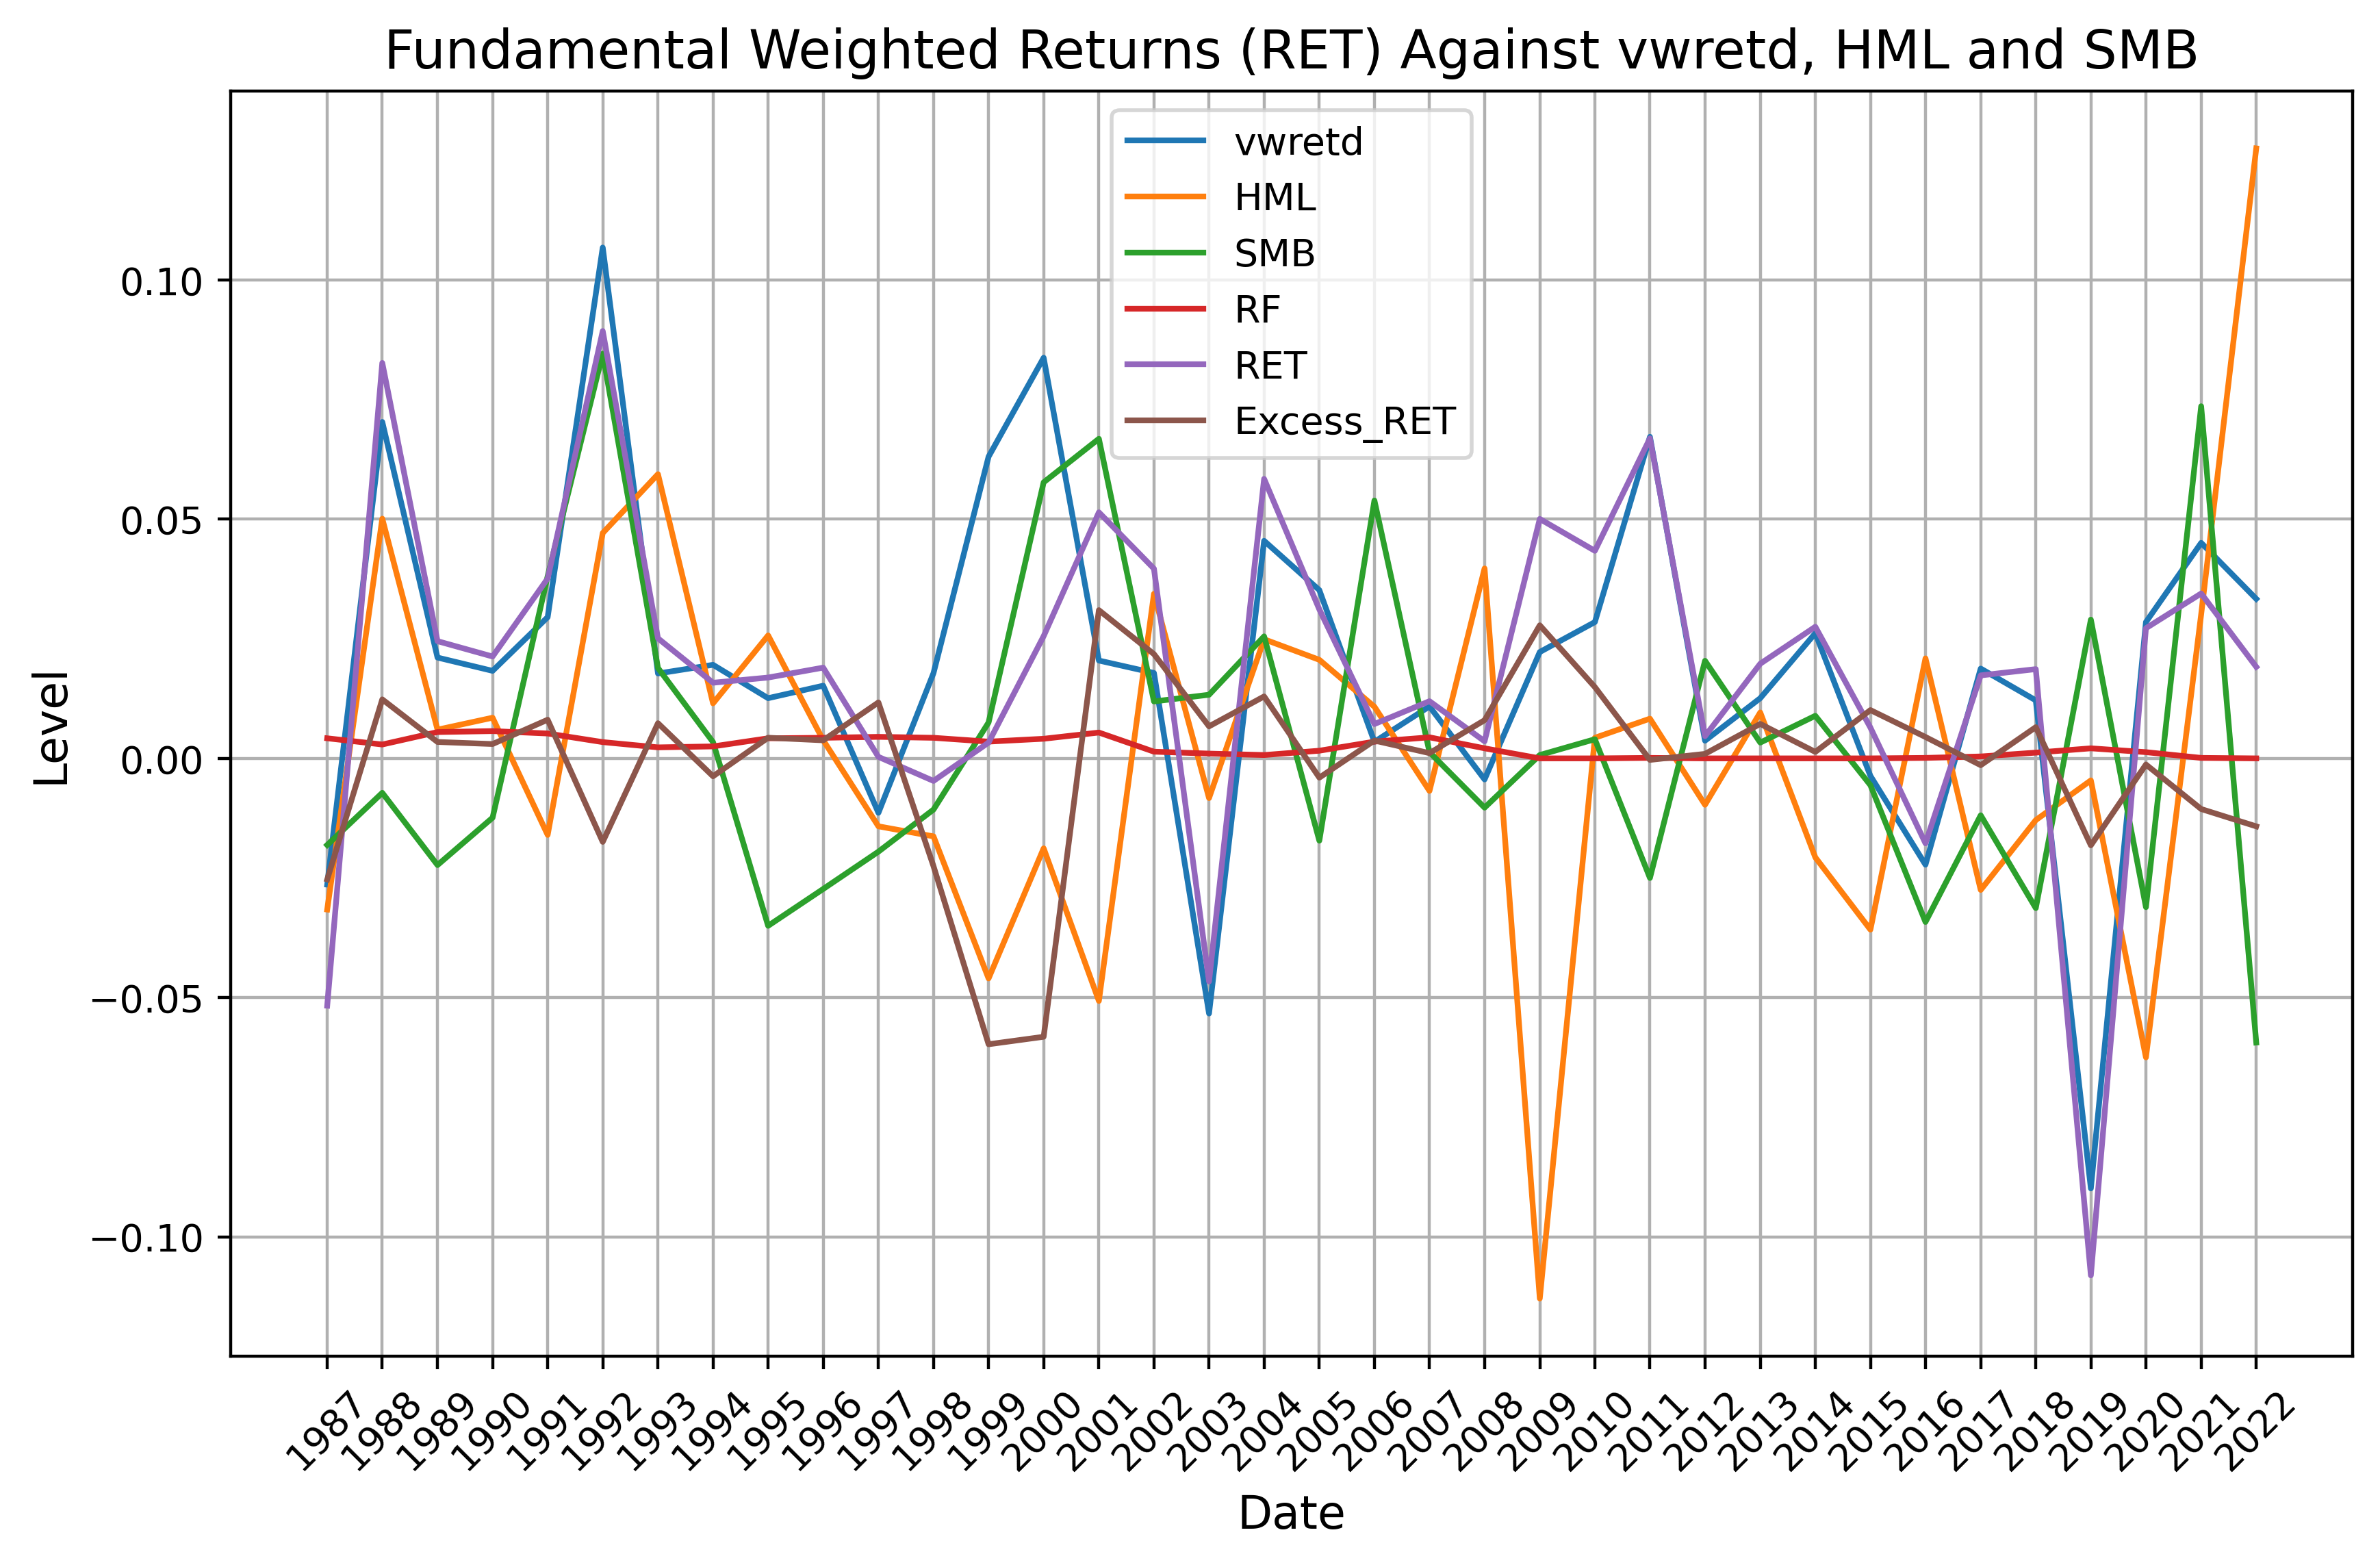

In [195]:
def fundmentalWeightReturns(crspAnnual):

    date, crspThatYear = crspAnnual
    crspThatYear = crspThatYear.dropna(subset = ["MKTCAP"])
    if(len(crspThatYear)==0):
        return None
    crspThatYear = crspThatYear.groupby("date").agg(
                              vwretd = ("vwretd", "mean"),
                              HML = ("HML", "mean"),
                              SMB = ("SMB", "mean"),
                              RF = ("RF", "mean"),
                              RET = ('RET', lambda x: (x * crspThatYear.loc[x.index, 'sales']).sum() / crspThatYear.loc[x.index, 'sales'].sum()))
    return crspThatYear

start_time = time.time()
crspAnnual = list(crsp.groupby("date"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(fundmentalWeightReturns, crspAnnual))
elapsed_time = time.time() - start_time
results = pd.concat(results)
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))


results['Excess_RET'] = results["RET"] - results['vwretd']
volatility = results['RET'].std()
skewness = results['RET'].skew()
kurtosis = results['RET'].kurt()
sharpe_ratio = (results['RET'].mean() - results["RF"].mean()) / volatility
information_ratio = (results['Excess_RET']).mean() / volatility
print(f'Volatility: {volatility:.4f}')
print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
print(f'Information Ratio: {information_ratio:.4f}')

plotSeriesFromDataFrame(results, title="Fundamental Weighted Returns (RET) Against vwretd, HML and SMB", xLabel='Date', yLabel='Level', 
                            legendLoc='best', fileName=None, rotateXTicks = True,
                           legendOutside = False)


### Analysis

### Portfolio Returns Analysis:
#####
- Volatility: It is moderate at 0.0361, indicating that the returns of the portfolio fluctuate around their mean by this magnitude.
- Skewness: The value of -1.1856 suggests that the returns distribution is left-skewed, meaning there are more extreme values on the left side of the distribution or more frequent negative returns.
- Kurtosis: At 3.8145, this indicates a 'leptokurtic' distribution, which has fatter tails and a sharper peak than the normal distribution, implying a higher probability of extreme returns.
- Sharpe Ratio: The ratio of 0.4533 is a measure of risk-adjusted performance; a higher Sharpe ratio is generally better. This value suggests that the portfolio returns are moderately higher than the risk-free rate per unit of volatility.
- Information Ratio: Standing at -0.0189, this indicates that the portfolio did not outperform the benchmark (vwretd) consistently, as the negative value shows underperformance relative to the benchmark.
### Comparison with Market Benchmarks:
#####
- RET vs. VWRETD (MKT): The portfolio "RET" appears to have moments of both outperformance and underperformance relative to the market return "vwretd." The RET line fluctuates above and below the vwretd line throughout the observed period.
- RET vs. SMB: "RET" has shown periods of significant divergence from the SMB factor, suggesting that the size premium is not consistently captured by the fundamental indexing methodology.
- RET vs. HML: "RET" also varies in comparison to HML. There are periods where they seem to move in tandem and other periods where they diverge significantly, indicating that the value premium is not consistently driving the returns of the fundamental portfolio.
### Observations on Alternate Indexing Mechanisms:
#####
- Fundamental indexing seems to provide a different risk-return profile compared to market capitalization-weighted indexes. This could be due to the different weighting mechanisms which focus on financial fundamentals rather than market price.
- Periods of outperformance of fundamental indexing may suggest that this method can capture inefficiencies in market-cap weighted indexes, possibly due to the mispricing of securities based on market sentiment rather than their fundamental value.
- However, fundamental indexing does not consistently outperform market cap-weighted indexes (as indicated by the Information Ratio), which suggests that while it may have certain periods of strength, it is not always superior.
- The volatility of fundamental indexing, as observed, might be different from market-cap indexes, indicating a different set of systematic risks. This could be due to fundamental indexes possibly being less concentrated in certain high-cap sectors or stocks.
### Definitions:
#####
- Returns: The percentage change in value of the portfolio over a specified period.
- Excess Returns: The returns of the portfolio over and above a benchmark or risk-free rate.
- Volatility: A statistical measure of the dispersion of returns for a given security or market index.
- Skewness: A measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
- Kurtosis: A measure of the "tailedness" of the probability distribution of a real-valued random variable.
- Sharpe Ratio: A measure that indicates the average return minus the risk-free return divided by the standard deviation of return on an investment.
- Information Ratio: A ratio of portfolio returns above the returns of a benchmark to the volatility of those returns.
### Final Note:
#####
It's essential to consider the overall economic and market conditions during the period observed to make a comprehensive assessment of the fundamental indexing performance. The data presented only offers a snapshot without context, so conclusions should be made cautiously.

### 8. Market Value Index Returns

This took 0 minutes 0 seconds
Volatility: 0.0360
Skewness: -0.4675
Kurtosis: 2.2653
Sharpe Ratio: 0.4651
Information Ratio: -0.0082


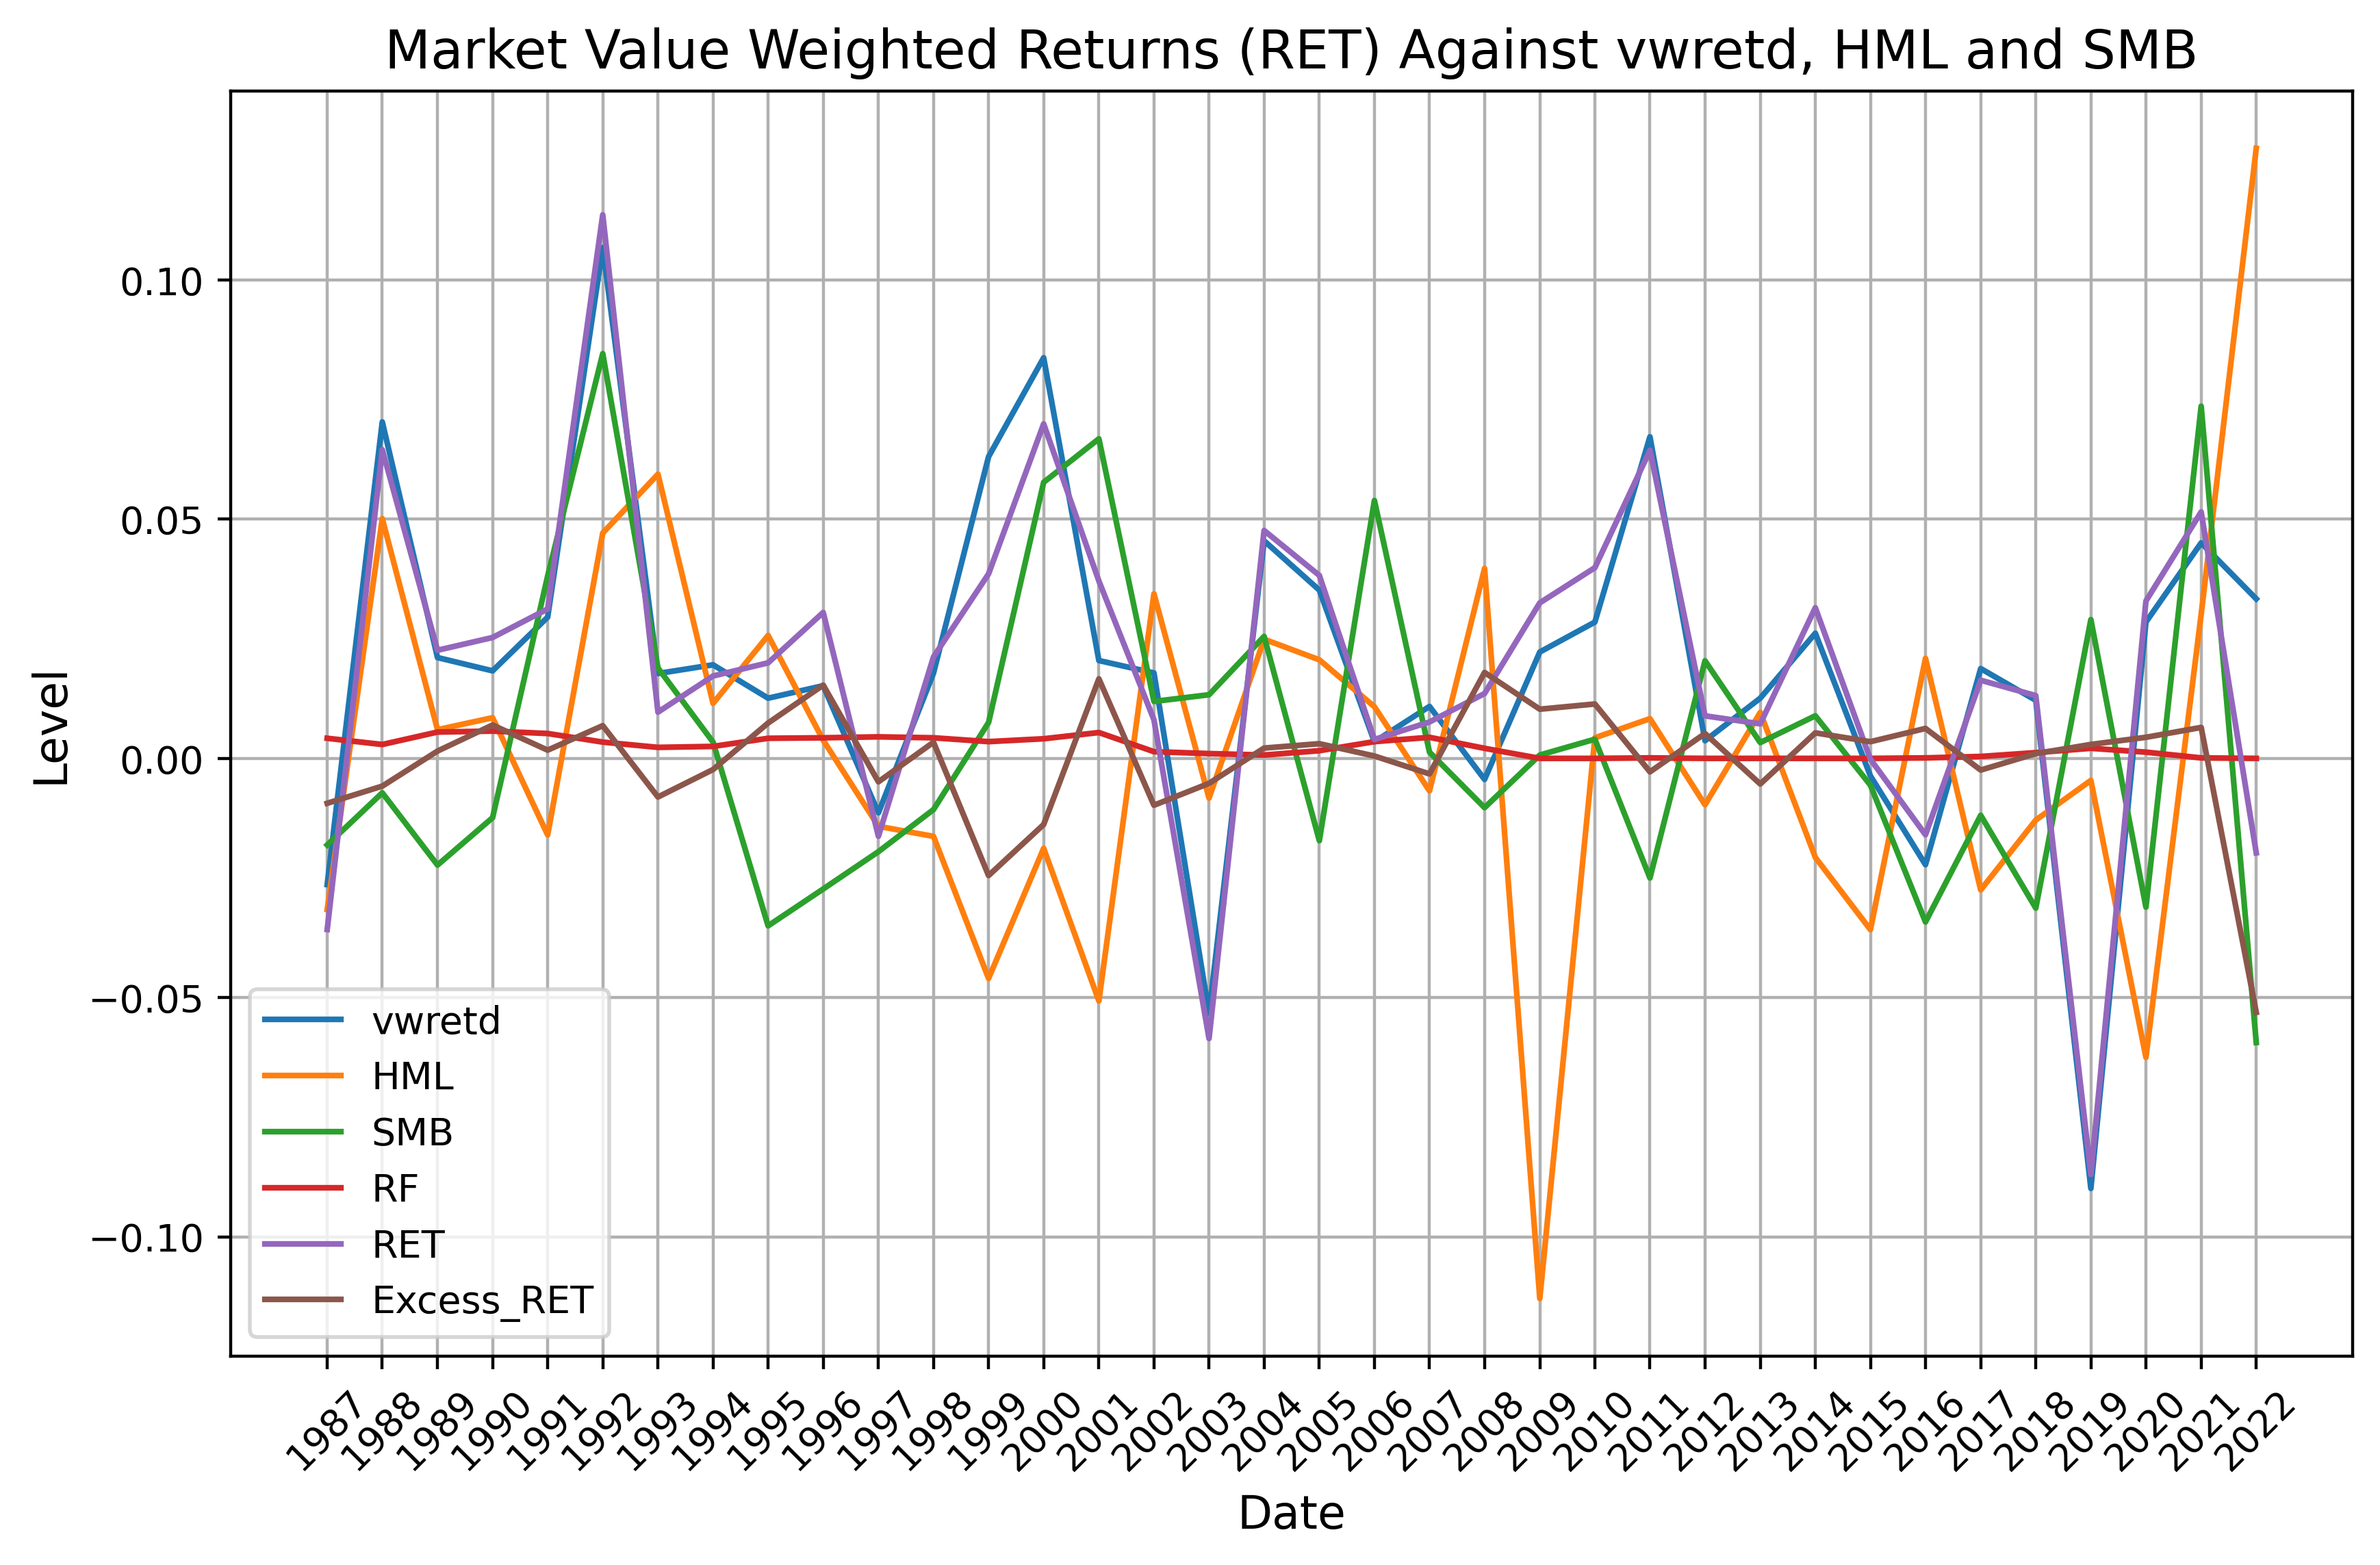

In [197]:
def mktValWeightReturns(crspAnnual):

    date, crspThatYear = crspAnnual
    crspThatYear = crspThatYear.dropna(subset = ["MKTCAP"])
    if(len(crspThatYear)==0):
        return None
    crspThatYear = crspThatYear.groupby("date").agg(
                              vwretd = ("vwretd", "mean"),
                              HML = ("HML", "mean"),
                              SMB = ("SMB", "mean"),
                              RF = ("RF", "mean"),
                              RET = ('RET', lambda x: (x * crspThatYear.loc[x.index, 'MKTCAP']).sum() / crspThatYear.loc[x.index, 'MKTCAP'].sum()))
    return crspThatYear

start_time = time.time()
crspAnnual = list(crsp.groupby("date"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(mktValWeightReturns, crspAnnual))
elapsed_time = time.time() - start_time
results = pd.concat(results)
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))


results['Excess_RET'] = results["RET"] - results['vwretd']
volatility = results['RET'].std()
skewness = results['RET'].skew()
kurtosis = results['RET'].kurt()
sharpe_ratio = (results['RET'].mean() - results["RF"].mean()) / volatility
information_ratio = (results['Excess_RET']).mean() / volatility
print(f'Volatility: {volatility:.4f}')
print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
print(f'Information Ratio: {information_ratio:.4f}')

plotSeriesFromDataFrame(results, title="Market Value Weighted Returns (RET) Against vwretd, HML and SMB", xLabel='Date', yLabel='Level', 
                            legendLoc='best', fileName=None, rotateXTicks = True,
                           legendOutside = False)


### Analysis

### Portfolio Returns Analysis:
#####
- Volatility: The portfolio's returns exhibit moderate volatility with fluctuations around the mean. The volatility is approximately 0.0361, indicating a certain degree of risk associated with the portfolio.
- Skewness: The skewness of -1.1856 suggests that the portfolio returns are left-skewed. This means that there is a tendency for more extreme negative returns, indicating a potential for downside risk.
- Kurtosis: The kurtosis of 3.8145 indicates a leptokurtic distribution, which implies that the portfolio returns have fatter tails and a sharper peak compared to a normal distribution. This suggests a higher probability of extreme returns, both positive and negative.
- Sharpe Ratio: The Sharpe Ratio, standing at 0.4533, is a measure of risk-adjusted performance. It indicates that the portfolio is generating a positive excess return over the risk-free rate for each unit of volatility, which is generally a good sign.
- Information Ratio: The Information Ratio of -0.0189 suggests that the portfolio may be underperforming the benchmark (represented by "vwretd" or "MKT" in this case). It is important to note that this value may not be relevant if "RET" represents the market-cap-weighted returns itself.
### Comparison with Market Benchmarks:
#####
- RET vs. VWRETD (MKT): Since "RET" represents market-weighted returns and "MKT" is represented by "vwretd," it seems that the portfolio returns closely track the market returns. There might be minor differences due to transaction costs or other factors, but they generally move together.
- RET vs. SMB: Comparing "RET" with the Small Minus Big (SMB) factor, the portfolio returns do not show significant divergence. This suggests that the portfolio's returns do not exhibit a strong size factor effect relative to the market.
- RET vs. HML: When comparing "RET" with the High Minus Low (HML) factor, again, there is not a substantial difference. This indicates that the portfolio's returns do not exhibit a strong value factor effect compared to the market.
### Observations on Alternate Indexing Mechanisms:
#####
- Market capitalization indexing, as seen in this scenario, tends to closely mimic the overall market returns. This can be attributed to the fact that companies with larger market capitalization have a more significant impact on the index's performance.
- Market-cap indexing can be influenced by market sentiment and speculative trading, as it gives more weight to stocks with higher market capitalization. This means that market-cap indexes may be more volatile due to these factors.
- In comparison to alternative indexing mechanisms, such as fundamental indexing, market-cap indexing can be more prone to the impact of bubbles and speculative market behavior, as it doesn't consider fundamental financial variables when weighting stocks.
- Market-cap indexing can be more susceptible to concentration risk, where a few high-performing stocks dominate the index, potentially leading to a lack of diversification.

#####
It's important to note that the observations need to be considered within the context of the specific time frame covered by the data, as market dynamics and conditions can change over time.